# Analysis of the outflow of bank customers

## Purpose and main tasks

The purpose of the study is to identify activities that can be carried out retain those who may leave and possibly to bring back departed customers.

Main tasks:
* segment customers into compact homogeneous segments;
* identify segments of customers who tend to leave the bank;
* form recommendations for retaining customers and returning those who have left.

## Data used

The dataset is provided by Yandex Practicum. The dataset contains data about the clients of the bank which is located in Russia, Yaroslavl and the regional cities of Rostov Veliky and Rybinsk.

Columns:
* userid — user identificator,
* score — credit scoring points,
* city — client's city of residence;
* gender — client's gender;
* age — client's age;
* equity — number of property points (according to methology of the bank with the help of which it values client's overall property);
* balance — client's account balance;
* products — number of products client is using;
* credit_сard — if client has a credit card or not (0-no, 1-yes);
* last_activity — if client recently has conducted significant transactions on the accounts (0-no, 1-yes);
* estimated_salary — clients estimated salary;
* churn — does the client have a high probability of outflow according to our bank's model or not (0-no, 1-yes).

## Decomposition of the work

1) Examining general information: what kind of data is presented and what information is available to us.\
2) Data preparation:
* Investigate data types and replace them if necessary;
* Encode categorical variables in the column with the city and gender using the one-hot method.
* Study the column names and bring them to a single style;
* Explore gaps: if possible, replace the omissions, delete or leave as is, depending on the type of omission:\
Research how columns with omissions correlate with the available data;\
MСAR omissions can be left or filled in with values that will not harm the distribution of column values.;\
MAR - we can fill in with the average/median for each group associated with a omission, taking into account the number of gaps;\
MNAR - it is impossible to fill in or delete omissions without additional justification, in such case the omissions will have to be left without intervention.
* Examine the data for explicit and implicit duplicates and delete them if allowed.

3) Exploratory data analysis:
* Examine the distribution of values of each column;
* View indicators of descriptive statistics for columns;
* Based on the average value, median, fashion, look at a typical customer in the context of high-quality and non-high-quality customers.
* Correlation analysis:\
Calculate and analyze correlations of data of all columns with a column with a sign of outflow using the phik coefficient;\
Graphically display the correlation using correlation matrices with a color scale for visual analysis;\
Select those parameters where the correlation score is higher than 10%.
* Study of portraits of outgoing clients:\
Compare quantitative portraits of clients, i.e. indicators of typical clients. Take the appropriate statistical value and calculate for each characteristic by how many percent this number is greater (less) for outflow clients compared to the non-outflow. What will be less than 10% modulo can be checked by stat. criterion for reliability.\
For the selected continuous values, plot the probability distribution density for the outflow and non-outflow clients to determine the ranges where the outflow is stronger than for the dataset as a whole.

4) Test hypotheses:
* For continuous variables use the Student's t-test or the Mann-Whitney u-test. Justify the choice. For the proportions test use the z-test for proportions.
* Test the hypothesis of income differences between those customers who are ready to leave and those who remain.
* Test the hypothesis of differences in average scoring numbers.
* Test the hypothesis of the difference in the average age of leaving and non-leaving clients.

5) Interim results and segmentation:
* To put together the results of the analysis and indicate which signs have the strongest effect on the outflow of clients and what values or ranges of values they take.
* Divide clients according to the criterias: the size of groups from 300 to 2000 people, the share of leaving clients in the group is at least 1.3 times higher than the average for the dataset.

6) Conclusions:
* Specify customer segments that tend to leave more often than others.
* Generate recommendations for returning customers and retaining customers who are inclined to leave.

# Let's study the general information about the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
! pip install missingno
import missingno as msno
! pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report
import numpy as np
import copy
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
import pylab 

In [2]:
data = pd.read_csv('bank_scrooge.csv')
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
print(f'In our table there are {data.shape[0]} rows and {data.shape[1]} columns.\
 There is information about {data.USERID.nunique()} clients from {data.city.nunique()} cities.')

In our table there are 10000 rows and 12 columns. There is information about 9927 clients from 3 cities.


Data types are specified correctly, the column names need to be slightly adjusted. There are omissions in the column with age and the amount of funds on the accounts.

In [5]:
data.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


In [6]:
print(f'According to data {data.churn.mean():.2%} clients are ready to leave.')

According to data 18.20% clients are ready to leave.


In [7]:
print(f'Only {data.last_activity.mean():.2%} of clients recently conducted significant activities.')

Only 52.35% of clients recently conducted significant activities.


Let's look at cities in our table.

In [8]:
data['city'].value_counts()

Ярославль    5888
Рыбинск      2695
Ростов       1417
Name: city, dtype: int64

Let's look how many products our clients have.

In [9]:
data['products'].value_counts()

2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: products, dtype: int64

In [10]:
print(f'In our datasets there are clients who have from {data.products.min()} to {data.products.max()} products.')

In our datasets there are clients who have from 0 to 5 products.


There is one client who doesn't use our services at all.

In [11]:
data[data['products']==0]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


An elderly woman from the city of Rybinsk, who has not done significant transactions for a long period of time. At the same time, she belongs to the category of clients who are ready to leave and we have no information about the amount of her assets. We can delete this client from our dataset.

In [12]:
data = data.drop([8957])

Let's see what property points our clients have.

In [13]:
data['equity'].value_counts()

0    2592
5    1918
4    1850
3    1542
2    1052
1     774
6     161
7      80
8      17
9      13
Name: equity, dtype: int64

In [14]:
print(f'In our datasets there are clients who have from {data.equity.min()} to {data.equity.max()} equity points.')

In our datasets there are clients who have from 0 to 9 equity points.


## Data preprocessing

### We need to change the column names. Let's bring it to the general style.

In [15]:
data = data.rename(
    columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})

In [16]:
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

### Duplicates

Let's find out if there are complete explicit duplicates.

In [17]:
data.duplicated().sum()

0

There are no obvious duplicates, We also need to check the people with the same ID.

In [18]:
data['user_id'].duplicated().sum()

73

In [19]:
print(f'As a percentage of the entire dataset, there are only\
 {data.user_id.duplicated().sum() / len(data):.2%} such clients.')

As a percentage of the entire dataset, there are only 0.73% such clients.


We should check how such duplicates look like, maybe there will be something to catch on to.

In [20]:
data[data['user_id'].duplicated()].head(7)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1583,190253,726.0,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0
1837,210662,896.0,Рыбинск,Ж,37.0,0,NaN,2,0,0,90916.04,0
2138,131419,739.0,Рыбинск,Ж,37.0,3,1307941.65,3,0,0,103867.47,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2302,220816,934.0,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
2998,208081,821.0,Рыбинск,Ж,62.0,3,493608.26,2,1,1,33491.45,0


Let's see how many leaving and non-leaving clients are among the duplicates, and how they are distributed between the cities.

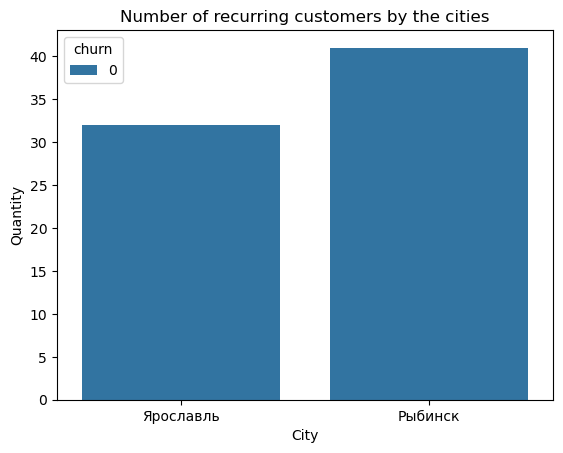

In [21]:
sns.countplot(data=data[data['user_id'].duplicated()], x='city', hue='churn')

plt.ylabel('Quantity')

plt.xlabel('City')

plt.title("Number of recurring customers by the cities")

plt.show()

We get that there are duplicated customers only in Yaroslavl and Rybinsk and only among those customers who are not going to leave the bank. Most likely, it has something to do with preparing or downloading information about the customers of these cities. So it's technical problem. We will remove such duplicates, since there are few of them.

In [22]:
data = data.drop_duplicates(subset='user_id')

## Exploring the gaps

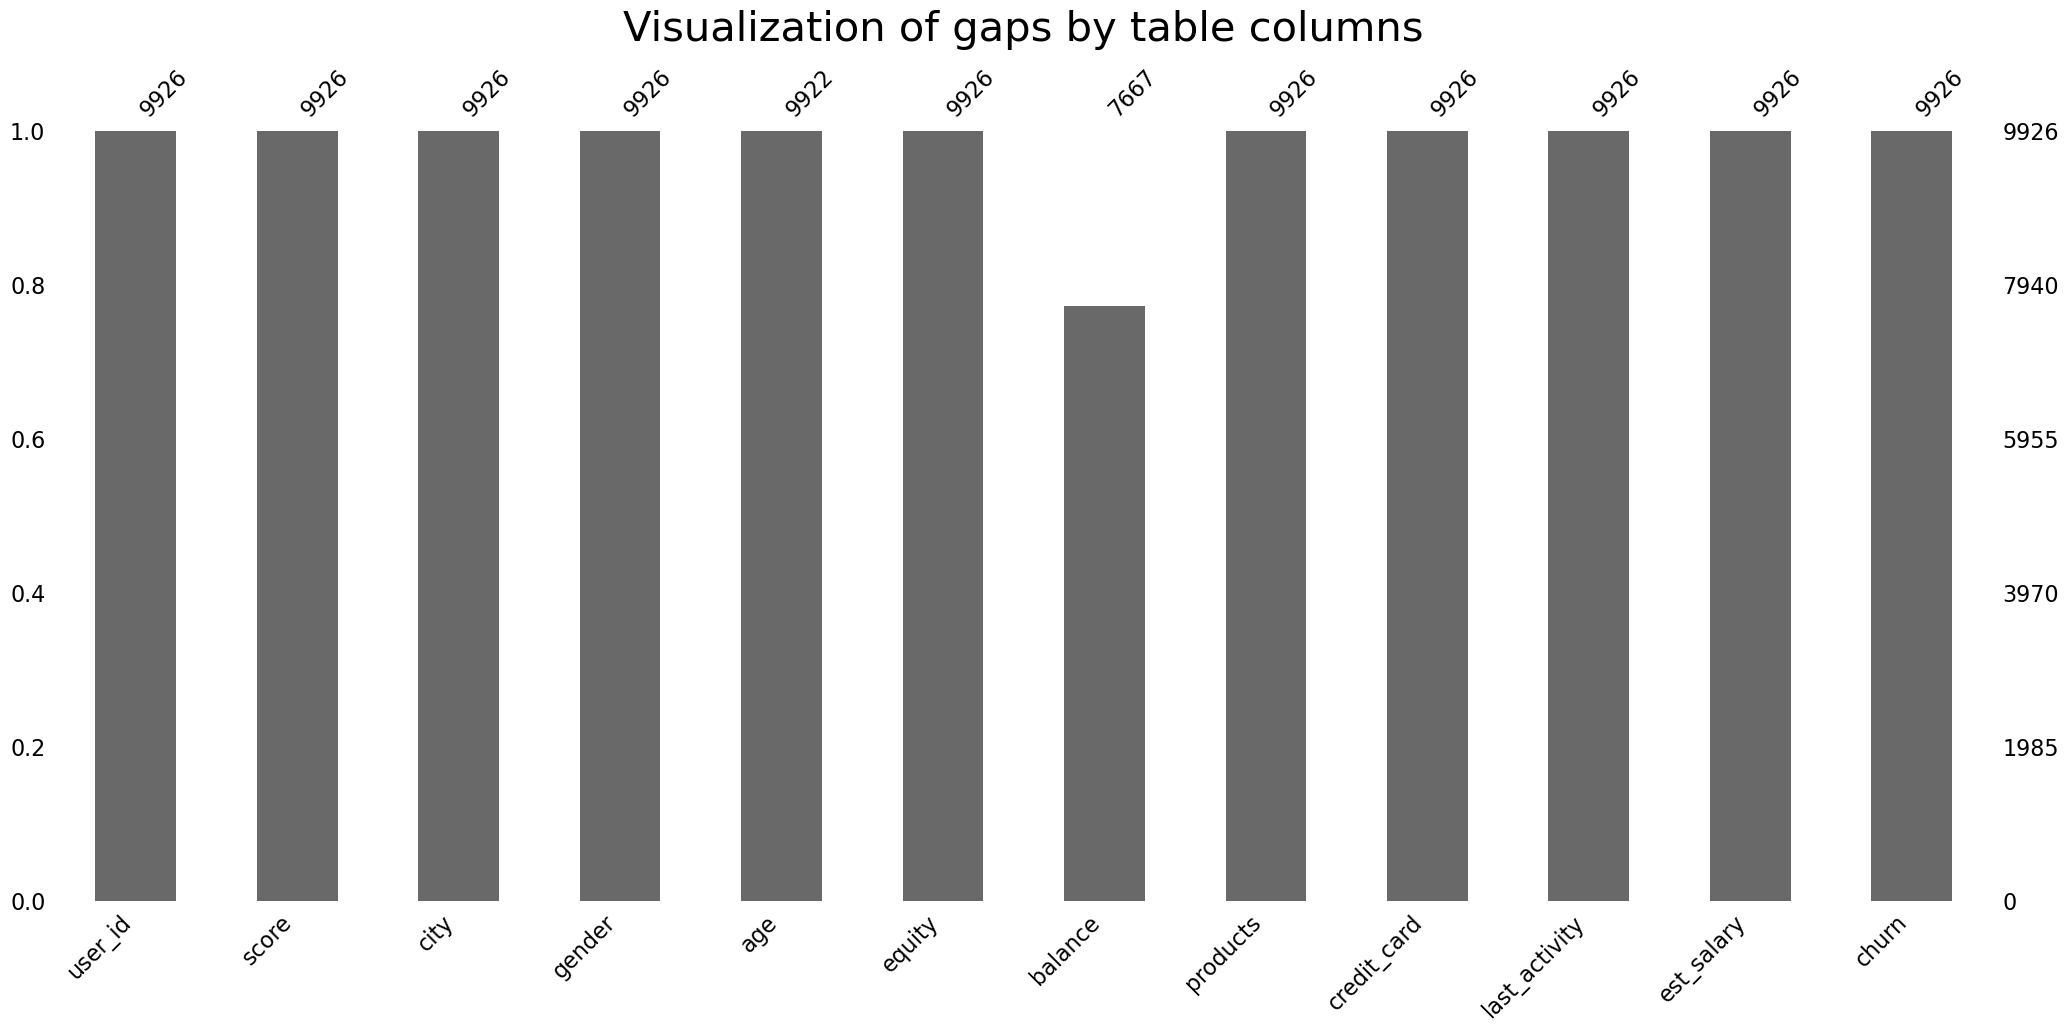

In [23]:
msno.bar(data)
plt.title("Visualization of gaps by table columns", pad=65, fontsize=30)
plt.show()

In [24]:
print(f'We have only {data.user_id.count()-data.age.count()} gaps in gender column\
 and {data.user_id.count()-data.balance.count()} gaps in balance column.')

We have only 4 gaps in gender column and 2259 gaps in balance column.


**Firstly, the clients with the missing age.**

In [25]:
data[data['age'].isna()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


We will delete them because there are just several such clients.

In [26]:
data=data.dropna(subset=['age'])

**Now we proceed to the gaps in the balance.**\
Firstly, we should look at the proportion the data with gaps has, depending on different categorical features.
Let's look at the proportion of omissions depending on the sign of "churn".

In [27]:
def missing_count (groupby):
    missing_grouped = 0
    missing_grouped = data[data['balance'].isna()].groupby(groupby)['user_id'].count()
    missing_grouped = missing_grouped / data.groupby(groupby)['user_id'].count() * 100
    return round(missing_grouped,2)

In [28]:
missing_count('churn')

churn
0    27.73
1     0.66
Name: user_id, dtype: float64

Among the clients with high-probability of leaving, only 0.66% of people have gaps in the balance. Those customers who probably will not leave the bank comprise more than a quarter of dataset. The gaps in the balance have a connection, at least, with the "churn" column. Let's see other columns.

Let's look at active and inactive clients.

In [29]:
missing_count('last_activity')

last_activity
0    21.53
1    23.90
Name: user_id, dtype: float64

Active and inactive clients have approximately the same number of missing values in the balance column. Most likely there is no connection with the gaps.

Now credit cards.

In [30]:
missing_count('credit_card')

credit_card
0    13.11
1    27.31
Name: user_id, dtype: float64

Customers with a credit card have gaps 2 times more often than other customers.

Let's look at the gaps in connection with the number of products.

In [31]:
products_miss = missing_count('products').reset_index().rename(
    columns={'user_id': 'product_missing,%'})
#products_miss

In [32]:
prod_id_count = data['products'].value_counts().reset_index().rename(
    columns={'index': 'products', 'products': 'id_count'})
#prod_id_count

In [33]:
prod_id_count.merge(products_miss, on='products')

,products,id_count,"product_missing,%"
0,2,5095,6.08
1,1,3306,58.11
2,3,1028,2.72
3,4,474,NaN
4,5,19,NaN


The more products, the fewer gaps in the balance. Almost all the omissions are from customers with 1 product. At the same time, there are even more customers with 2 products in the bank than with 1. And we also remember that almost all of these customers are not going to leave the bank. Perhaps these are customers who do not use a bank account, but have some other 1 product, for example, insurance or only a brokerage account.
It is necessary to ask such a question to the compilers of the database, perhaps it will be possible to make it more comprehensible.

In [34]:
data[data['balance']==0]['user_id'].count()

2

There are only 2 people with empty accounts in the dataset. Perhaps the omissions are related to empty accounts. Usually, banks automatically open an account when accepting a client for service. And even if the client does not use it, the client has a zero(empty) account.

Let's look at the connection of gaps with property points.

In [35]:
equity_balance_isna = missing_count('equity')

In [36]:
data['equity'].value_counts().reset_index().sort_values(by='index').rename(
    columns={'index': 'equity_score'}).join(equity_balance_isna, on='equity_score').set_index('equity_score')

,equity,user_id
equity_score,,
0,2554,83.99
1,771,14.79
2,1046,NaN
3,1531,NaN
4,1841,NaN
5,1909,NaN
6,161,NaN
7,79,NaN
8,17,NaN


We see that the clients who have the least property have the largest share of omissions in the balance. And at the same time, these are still non-leaving customers and they most often have 1 product. It is quite possible that these customers have empty accounts, they do not use them or do not have them at all in our bank.

Let's see how the gaps in the balance are distributed by gender and cities.

In [37]:
missing_count('gender')

gender
Ж    20.11
М    25.41
Name: user_id, dtype: float64

In [38]:
missing_count('city')

city
Ростов       16.60
Рыбинск      21.68
Ярославль    24.75
Name: user_id, dtype: float64

By city and gender, the shares of passes are distributed without large distortions.

As a result, almost all the omissions come from customers who are not going to leave the bank. And at the same time, the vast majority of gaps are from customers with 0 equity points and 1 product.
Accordingly, the omissions have a high relationship with the column "churn", "equity" and "products".

**Let's look at the correlation matrix to evaluate the relationship of the column with the balance and the relationship of gaps in the column with other columns.**

Let's add a new column, where 0 means no gap in balance column, and 1 means its presence.

In [39]:
def miss_balance (balance):
    if balance >= 0:
        return 0
    else:
        return 1
    
data['missing_balance'] = data['balance'].apply(miss_balance)
#data['missing_balance'].head(20)

In [40]:
balance_phik = data.set_index("user_id")

In [41]:
interval_cols = ['score', 'age', 'balance', 'est_salary']
phik_overview = balance_phik.phik_matrix(interval_cols=interval_cols)

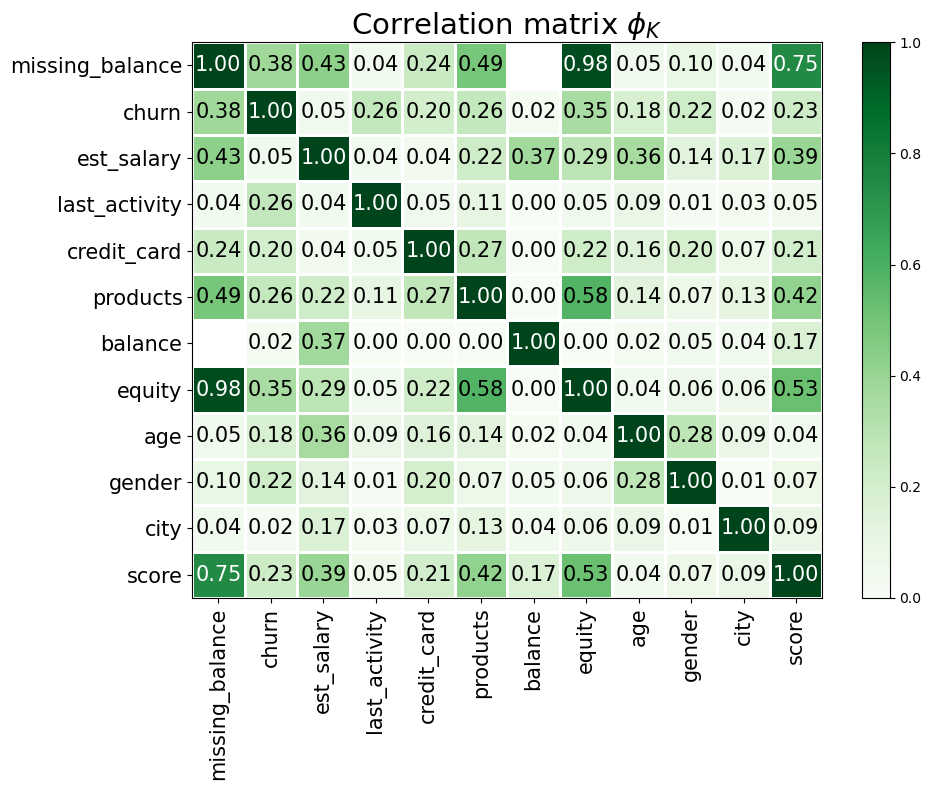

In [42]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Correlation matrix $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

As we noticed earlier, there is a strong relationship between the presence and absence of omissions with the outflow/non-outflow sign, with the number of products and the strongest relationship with equity scores. In addition, there is a high connection with scoring points and salary.

Let's look at how the salary and scoring values are distributed in case of gaps in the balance sheet.
Let's start with scoring estimates.
We can also notice that the "score" from the data correlates most strongly with the number of products the client has and the property points. As are the gaps in the balance.

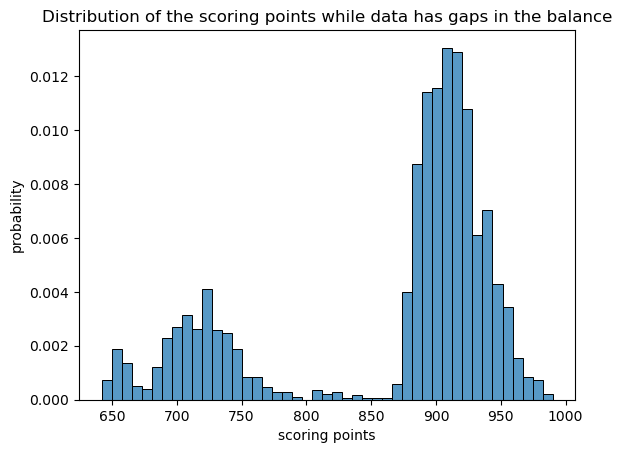

In [43]:
sns.histplot(data.loc[data['missing_balance']==1]['score'],stat='density')
plt.title('Distribution of the scoring points while data has gaps in the balance')
plt.ylabel('probability')
plt.xlabel('scoring points')
plt.show()

There are two peaks. The first is about 730 points and the second is about 910 points.

Let's look at the distribution of scoring points when there are no gaps in the balance.

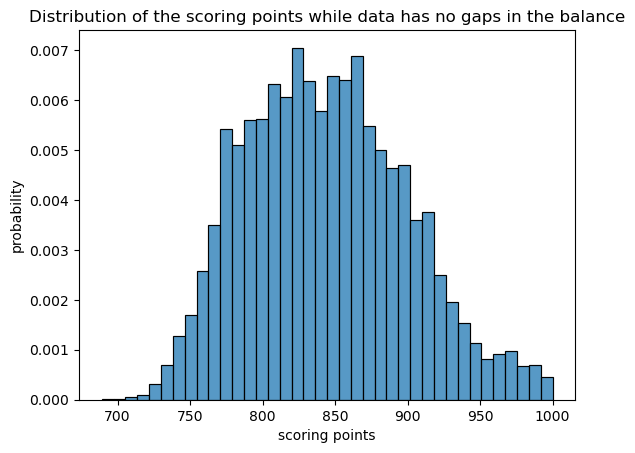

In [44]:
sns.histplot(data.loc[data['missing_balance']==0]['score'],stat='density')
plt.title('Distribution of the scoring points while data has no gaps in the balance')
plt.ylabel('probability')
plt.xlabel('scoring points')
plt.show()

Scoring points with no gaps in the balance have one peak around of 820. Let's calculate the medians of the scoring points when there are gaps and when there are none.

In [45]:
# no gaps
data.loc[data['missing_balance']==0]['score'].median()

841.0

In [46]:
# there are gaps
data.loc[data['missing_balance']==1]['score'].median()

903.0

Clients with omissions have a higher median. Which is strange, because the gaps are mostly for those who have 0 property points and 1 product. It turns out the median of their scoring is higher.

We will do the same research for the salary.

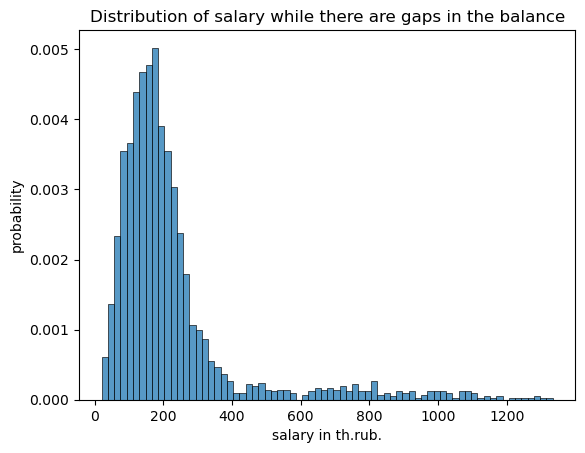

In [47]:
# there are gaps in the balance
sns.histplot(data.loc[data['missing_balance']==1]["est_salary"]/1000,stat='density')
plt.title('Distribution of salary while there are gaps in the balance')
plt.ylabel('probability')
plt.xlabel('salary in th.rub.')
plt.show()

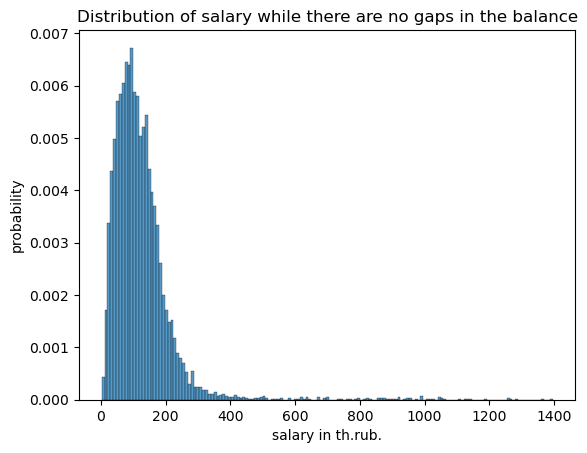

In [48]:
# there are gaps in the balance
sns.histplot(data.loc[data['missing_balance']==0]["est_salary"]/1000,stat='density')
plt.title('Distribution of salary while there are no gaps in the balance')
plt.ylabel('probability')
plt.xlabel('salary in th.rub.')
plt.show()

At first glance, the distributions are similar, but the peak of the graph with gaps is closer to 200. Let's calculate the medians when there are gaps and when there are none.

In [49]:
# there are gaps, median in th.rubles
(data.loc[data['missing_balance']==0]["est_salary"]/1000).median()

106.3552

In [50]:
# there are no gaps, median in th.rubles
(data.loc[data['missing_balance']==1]["est_salary"]/1000).median()

174.76717000000002

For clients with gaps, the salary is higher. But from this information, we can only conclude that the omissions are mostly occur for wealthier people with higher scoring points.

A more interpretable and useful conclusion is that the vast majority of omissions are from customers with 0 ownership points and 1 product. We can bring this information to the database administrators and look with them why this could happen.

**Let's see if we can somehow fill in the gaps in the balance.**

The balance correlates most strongly with salary. Let's see how the salary can be divided into groups depending on the balance.

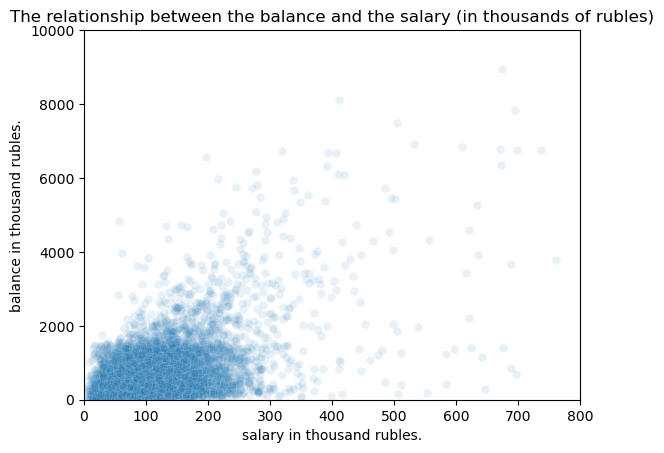

In [51]:
sns.scatterplot(x=data["est_salary"]/1000,
              y=data["balance"]/1000,
              data=data,
              alpha=0.10)
plt.xlim(0, 800)
plt.ylim(0, 10000)
plt.title('The relationship between the balance and the salary (in thousands of rubles)')
plt.ylabel('balance in thousand rubles')
plt.xlabel('salary in thousand rubles')
plt.show()

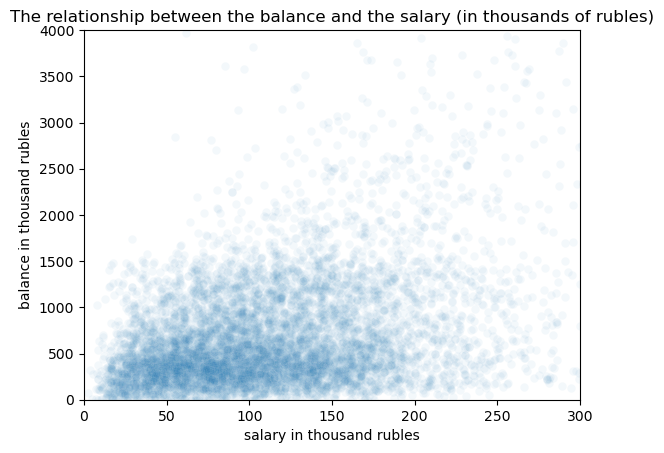

In [52]:
sns.scatterplot(x=data["est_salary"]/1000,
              y=data["balance"]/1000,
              data=data,
              alpha=0.05)
plt.xlim(0, 300)
plt.ylim(0, 4000)
plt.title('The relationship between the balance and the salary (in thousands of rubles)')
plt.ylabel('balance in thousand rubles')
plt.xlabel('salary in thousand rubles')
plt.show()

The largest part of the values is in the rectangle, where the balance is up to 1.5 million rubles, and the salary is up to 200 thousand rubles.
We see that with a salary increase above 100 thousand rubles, values with a balance above 2 million rubles begin to appear more often.
And with the growth of the salary above 150 thousand, balance values above 3 billion rubles begin to appear more often.
We can take three groups: salary up to 100 thousand rubles, from 100 to 150, from 150 and above.
Let's look at the median balance for such salaries.

In [53]:
data.query('est_salary<100000')['balance'].median()

417031.67

In [54]:
data.query('est_salary>=100000 and est_salary<150000')['balance'].median()

550172.74

In [55]:
data.query('est_salary>=150000')['balance'].median()

826470.915

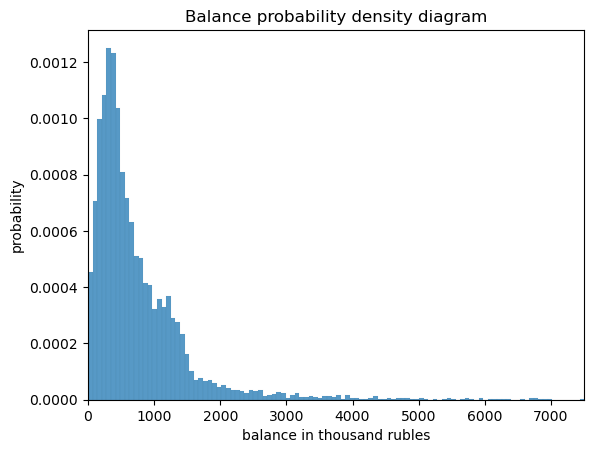

In [56]:
sns.histplot(data['balance']/1000,stat='density')
plt.xlim(0, 7500)
plt.title('Balance probability density diagram')
plt.ylabel('probability')
plt.xlabel('balance in thousand rubles')
plt.show()

The distribution of balance values is strongly shifted to the right. If we replace the gaps in the balance sheet with medians for three groups based on salary, we will greatly increase the number of balance values before 1 million rubles.
The gaps are about a quarter of the entire dataset, so we will leave the gaps and will not touch them. Moreover, they are most likely associated with those customers who for some reason do not have a bank account or have zero balances there.
The most important thing is that these are not leaving clients. When we make portraits of the most refined clients, these omissions will not hurt us.

## Encoding the variables in the column with the city and gender

**Cities.**\
We have 3 cities. We will create a separate column for each city. If the string corresponds to this city, it will be 1, i.e. True.\
Similarly for gender. We will use the pandas method.get_dummies().

In [57]:
data_initial = copy.deepcopy(data)
data = pd.get_dummies(data)

In [58]:
data = data.rename(columns={'city_Ростов': 'rostov', 'city_Рыбинск': 'rybinsk', 'city_Ярославль': 'yaroslavl', 
                     'gender_Ж': 'female', 'gender_М':'male'})
data.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,rostov,rybinsk,yaroslavl,female,male
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,0,1,0,1,0
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,0,1,0,1,0
2,120722,892.0,30.0,0,NaN,1,1,1,107683.34,0,1,0,1,0,1,0
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,0,1,1,0
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,0,1,0,1


# Exploratory data analysis

## Exploring the distributions of discrete and continuous variables

For convenience, we will create additional columns with an estimate of the balance and salary in thousands of rubles.

In [59]:
data['est_salary_th'] = data['est_salary']/1000
data['balance_th'] = data['balance']/1000

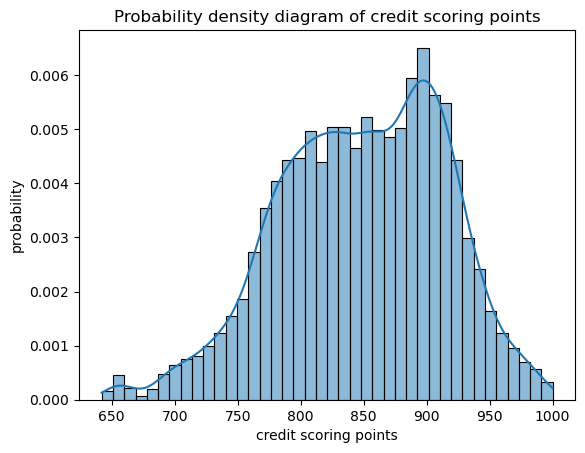

In [60]:
sns.histplot(data['score'],stat='density', kde=True)
plt.title('Probability density diagram of credit scoring points')
plt.ylabel('probability')
plt.xlabel('credit scoring points')
plt.show()

The distribution is skewed to the left, but without very long tails. The majority of customers have scores of 800 or more. In general, the bank assesses the creditworthiness of customers with high marks.

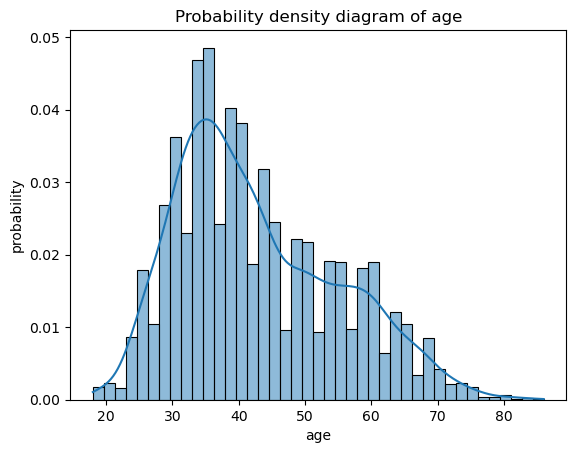

In [61]:
sns.histplot(data['age'],stat='density', kde=True)
plt.title('Probability density diagram of age')
plt.ylabel('probability')
plt.xlabel('age')
plt.show()

The distribution is skewed to the right, but without very long tails. The bank is focused on clients from 30 to 50 years old.

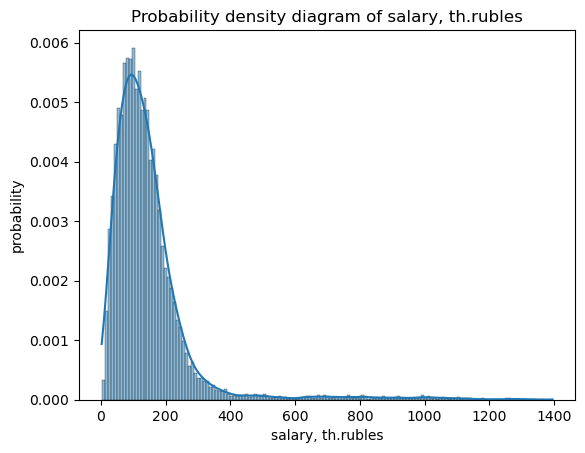

In [62]:
sns.histplot(data['est_salary_th'],stat='density', kde=True)
plt.title('Probability density diagram of salary, th.rubles')
plt.ylabel('probability')
plt.xlabel('salary, th.rubles')
plt.show()

Very long tail on the right. Up to almost 1.5 million rubles. But salaries above 400 thousand rubles are rare.

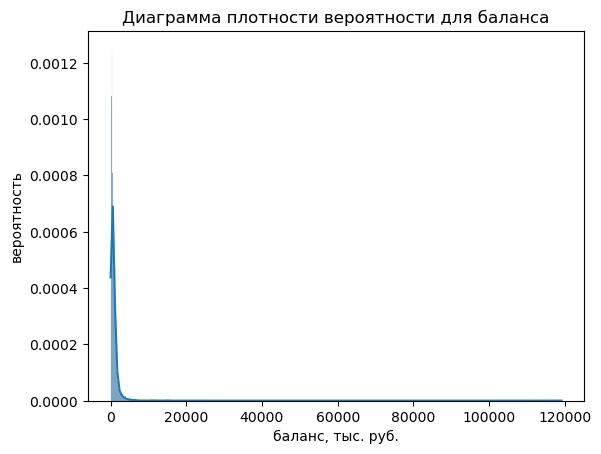

In [63]:
sns.histplot(data['balance_th'],stat='density', kde=True)
plt.title('Probability density diagram of balance, th.rubles')
plt.ylabel('probability')
plt.xlabel('balance, th.rubles')
plt.show()

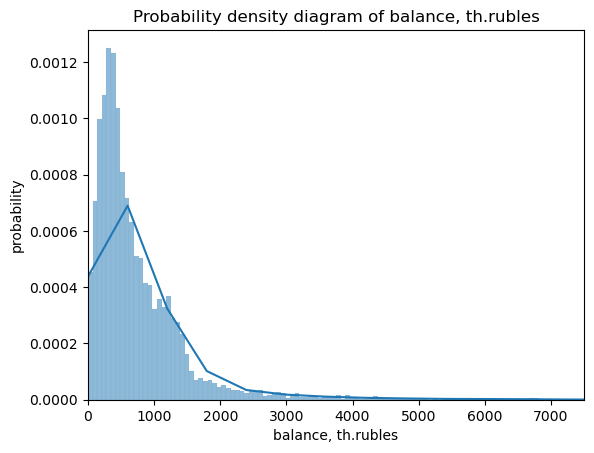

In [64]:
sns.histplot(data['balance_th'],stat='density', kde=True)
plt.title('Probability density diagram of balance, th.rubles')
plt.ylabel('probability')
plt.xlabel('balance, th.rubles')
plt.xlim(0, 7500)
plt.show()

We also have a very long tail here. Up to 120 million rubles. But the majority of customers have a balance of up to 3 million rubles.

## Typical customer

Let's see how we can characterize an ordinary client of our bank. For convenience, we will create additional columns with an estimate of the balance and salary in thousands of rubles.

In [65]:
description_table = data[["score", "age", "equity", "products", "credit_card", "last_activity", "churn",
      "rostov", "yaroslavl", "rybinsk", "female", "male", "est_salary_th", "balance_th"]].describe()
description_table

,score,age,equity,products,credit_card,last_activity,churn,rostov,yaroslavl,rybinsk,female,male,est_salary_th,balance_th
count,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,9922.000000,7663.000000
mean,848.720923,42.725559,2.634247,1.871699,0.680105,0.523382,0.183229,0.142713,0.590002,0.267285,0.499093,0.500907,147.898874,828.248160
std,65.393520,12.172175,1.979425,0.792928,0.466459,0.499478,0.386874,0.349798,0.491858,0.442565,0.500024,0.500024,139.365465,1984.247693
min,642.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.546300,0.000000
25%,802.000000,33.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.254045,295.498985
50%,853.000000,40.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,119.735430,524.961220
75%,900.000000,51.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,174.679638,980.801490
max,1000.000000,86.000000,9.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1395.064450,119113.552010


Having studied this table, we see that there is no unrealistic information. The biggest variabilities of values are in the salary and balance column. But the bank also have very wealthy clients, so numbers are real. Therefore, we will not delete scuh data and there is no point in looking at the boxplot.
To study typical values for categorical features we will take mode, median for salary and balance, and average for discrete ones.

For categorical variables let's look at the mode.

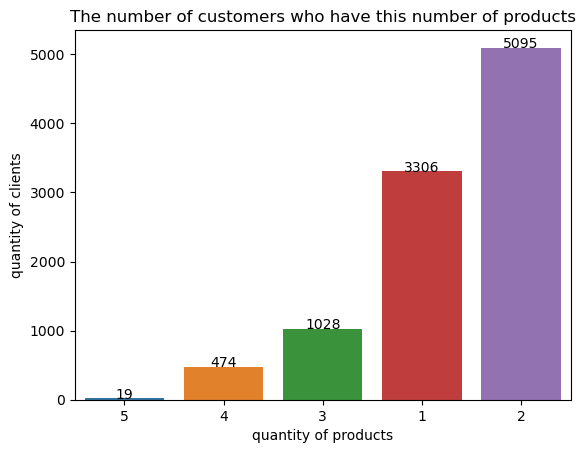

In [66]:
order = data.groupby('products')['user_id'].count().reset_index().sort_values(by='user_id')

ax = sns.countplot(x=data['products'], order=order['products'])

plt.ylabel('quantity of clients')

plt.xlabel('quantity of products')

plt.title("The number of customers who have this number of products")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height), 
 ha = 'center') 
plt.show()

Accordingly, the most popular number of products among customers is 2. This is mode. In addition, there is often a customer with 1 product.

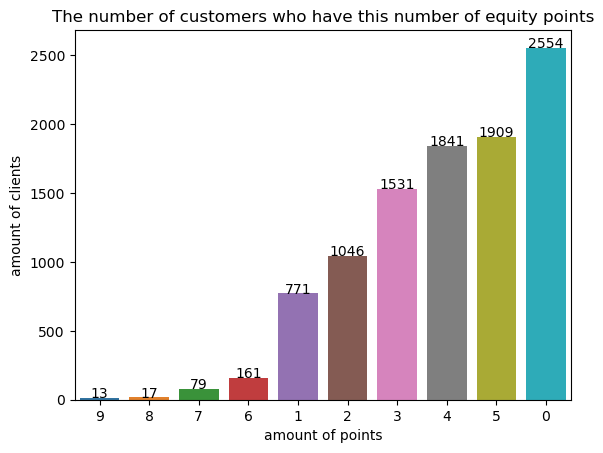

In [67]:
order = data.groupby('equity')['user_id'].count().reset_index().sort_values(by='user_id')

ax = sns.countplot(x=data['equity'], order=order['equity'])

plt.ylabel('amount of clients')

plt.xlabel('amount of points')

plt.title("The number of customers who have this number of equity points")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height),
 ha = 'center') 

plt.show()

More often customers have 0 points. Then, with almost the same frequency, 5,4,3 points.

In [68]:
np.sort(data['last_activity'].unique())[:]

array([0, 1], dtype=int64)

In [69]:
def bar_chart(x_data):
    ax = sns.countplot(x=data[x_data])
    plt.ylabel('amount of clients')
    plt.xlabel('column values')
    labels = ['thre is', 'there isnt']
    plt.xticks(np.sort(data['last_activity'].unique()), labels)

    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.0f}'.format(height),
        ha = 'center')

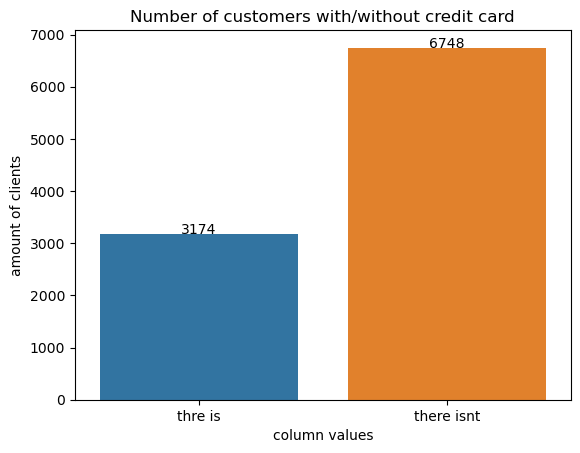

In [70]:
bar_chart('credit_card')

plt.title("Number of customers with/without credit card")

plt.show()

The vast majority of customers have a credit card.

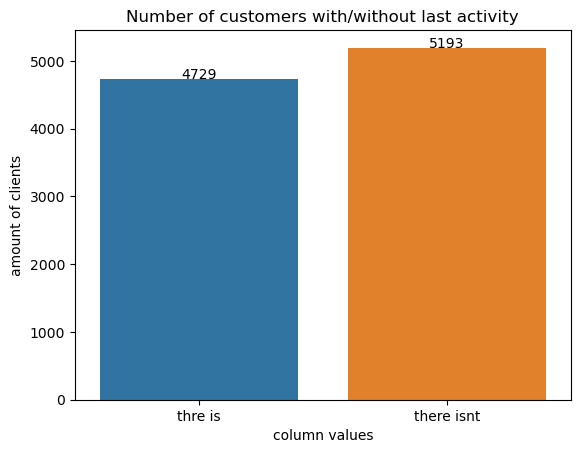

In [71]:
bar_chart('last_activity')

plt.title("Number of customers with/without last activity")

plt.show()

The number of people who recently had and did not have significant activity approximately equal.

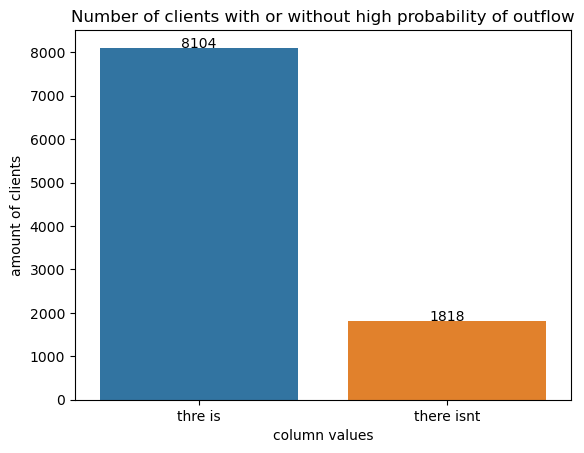

In [72]:
bar_chart('churn')

plt.title("Number of clients with or without high probability of outflow")

plt.show()

In [73]:
print(f'According to our data {data.churn.mean():.2%} customers are ready to leave.')

According to our data 18.32% customers are ready to leave.


Now let's look at the cities and the gender.

In [74]:
columnar_city = data.melt(value_vars=['rostov', 'rybinsk', 'yaroslavl']) 
#columnar_city.head()

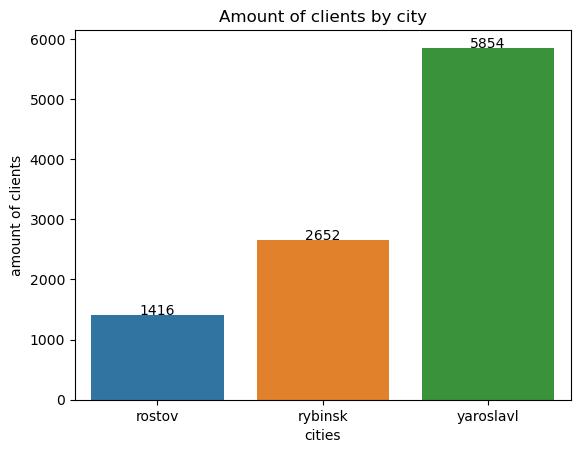

In [75]:
columnar_city = columnar_city.groupby('variable')['value'].sum().reset_index().sort_values(by='value')

ax = sns.barplot(x='variable', y='value', data=columnar_city)

plt.ylabel('amount of clients')

plt.xlabel('cities')

plt.title("Amount of clients by city")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height),
 ha = 'center') 

plt.show()

The main part of our clients are from Yaroslavl. More than half of all customers. From Rostov the least of all.

In [76]:
columnar_gender = data.melt(value_vars=['female', 'male'])
#columnar_gender.head()

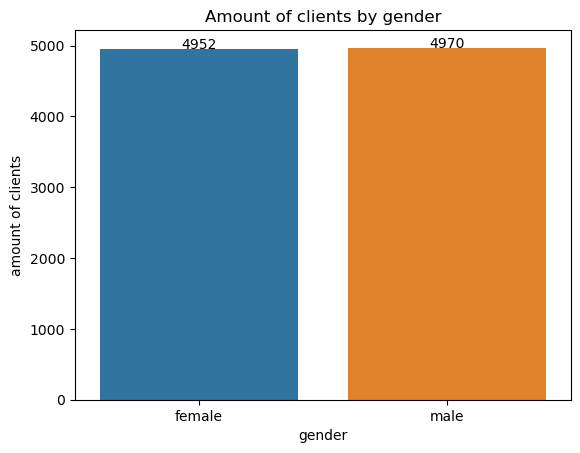

In [77]:
columnar_gender = columnar_gender.groupby('variable')['value'].sum().reset_index().sort_values(by='value')

ax = sns.barplot(x='variable', y='value', data=columnar_gender)

plt.ylabel('amount of clients')

plt.xlabel('gender')

plt.title("Amount of clients by gender")

for p in ax.patches:
 height = p.get_height() 
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+0.05, 
 s = '{:.0f}'.format(height),
 ha = 'center') 

plt.show()

Approximately equal number of women and men.

**Interim conclusion. Portrait of typical client.**

In [78]:
print(f'A typical client of our bank lives in Yaroslavl, has an age {round(description_table.age[1],2)},\
 income {round(description_table.est_salary_th[5],2)} th.rub. per month,\
 balance on the account {round(description_table.balance_th[5],2)} th. rub.')

A typical client of our bank lives in Yaroslavl, has an age 42.73, income 119.74 th.rub. per month, balance on the account 524.96 th. rub.


In [79]:
print("With the same probability it can be both a man and a woman.\
 Usually the customer has two banking products and 0 equity points, has a credit card.")

With the same probability it can be both a man and a woman. Usually the customer has two banking products and 0 equity points, has a credit card.


In [80]:
typical_client=pd.DataFrame(
{"indicator":["age", "gender", "city", "salary,th.rub.", 
              "balance,th.rub.", "products", "equity", "churn/no churn", "credit card", "activity"],
 "значение":[42.73, "M/F", "Yaroslavl", 119.74, 524.96, 2, 0, "no churn", "there is", "there is not"]})

All this we can use as a general summary table.

In [81]:
typical_client

,indicator,значение
0,age,42.73
1,gender,M/F
2,city,Yaroslavl
3,"salary,th.rub.",119.74
4,"balance,th.rub.",524.96
5,products,2
6,equity,0
7,churn/no churn,no churn
8,credit card,there is
9,activity,there is not


## Examining a typical leaving client

Let's look at a typical leaving client in comparison with a non-leaving one.

In [82]:
description_table_1_churn = (data.loc[data['churn']==1][["score", "age", "equity", "products", 
                            "credit_card", "last_activity", "churn", "rostov", "yaroslavl", 
                            "rybinsk", "female", "male", "est_salary_th", "balance_th"]].describe())
description_table_1_churn

,score,age,equity,products,credit_card,last_activity,churn,rostov,yaroslavl,rybinsk,female,male,est_salary_th,balance_th
count,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.0,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1806.000000
mean,863.361936,41.429593,3.763476,2.377338,0.551705,0.702420,1.0,0.145765,0.614411,0.239824,0.349285,0.650715,148.357483,1134.458209
std,49.580696,11.144754,1.586316,0.922162,0.497456,0.457319,0.0,0.352967,0.486868,0.427093,0.476875,0.476875,122.931982,2034.445549
min,706.000000,18.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.880270,0.006000
25%,828.000000,32.000000,3.000000,2.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,83.285660,387.482165
50%,866.000000,39.000000,4.000000,2.000000,1.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,125.408880,783.908900
75%,898.000000,52.000000,5.000000,3.000000,1.000000,1.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,176.017838,1348.127553
max,1000.000000,75.000000,9.000000,5.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1263.028490,64866.210150


In [83]:
description_table_0_churn = (data.loc[data['churn']==0][["score", "age", "equity", "products", 
                            "credit_card", "last_activity", "churn", "rostov", "yaroslavl", 
                            "rybinsk", "female", "male", "est_salary_th", "balance_th"]].describe())
description_table_0_churn

,score,age,equity,products,credit_card,last_activity,churn,rostov,yaroslavl,rybinsk,female,male,est_salary_th,balance_th
count,8104.000000,8104.000000,8104.000000,8104.000000,8104.000000,8104.000000,8104.0,8104.000000,8104.000000,8104.000000,8104.00000,8104.00000,8104.000000,5857.000000
mean,845.436451,43.016288,2.380923,1.758268,0.708909,0.483218,0.0,0.142029,0.584526,0.273445,0.53270,0.46730,147.795992,733.828602
std,68.012034,12.372982,1.970443,0.713358,0.454293,0.499749,0.0,0.349101,0.492834,0.445755,0.49896,0.49896,142.799302,1959.055429
min,642.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,2.546300,0.000000
25%,796.000000,34.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,73.487070,279.004830
50%,848.000000,40.000000,3.000000,2.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.00000,0.00000,118.248515,475.354800
75%,900.000000,51.000000,4.000000,2.000000,1.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.00000,1.00000,174.106043,853.826360
max,1000.000000,86.000000,9.000000,5.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.00000,1.00000,1395.064450,119113.552010


We can visualize the differences for categorical variables.
For convenience, we will add a column that will use words to denote leaving and non-leaving customers.

In [84]:
def churn_str (churn):
    if churn == 0:
        return 'non-leaving'
    else:
        return 'leaving'

In [85]:
data['churn_str'] = data['churn'].apply(churn_str)
#data['churn_str'].head()

**Let's start with the number of products.**

In [86]:
def churn_groups (data, column):
    churn_groups = data.groupby(['churn_str',column])['user_id'].count().reset_index()
    churn_groups['sum'] = 0 
    
    #calculating the sum for all non-leaving and leaving clients and put it in the sum column
    churn_groups.loc[churn_groups['churn_str']=='non-leaving','sum']= \
    churn_groups[churn_groups['churn_str']=='non-leaving']['user_id'].sum()
    churn_groups.loc[churn_groups['churn_str']=='leaving','sum']= \
    churn_groups[churn_groups['churn_str']=='leaving']['user_id'].sum()
    
    #calculating the share of each group in the total number of outgoing and non-outgoing
    churn_groups['ratio']=round(churn_groups['user_id']/churn_groups['sum']*100,2)
    return churn_groups, churn_groups.loc[churn_groups['churn_str']=='leaving']

In [87]:
products_churn, products_churn_1 = churn_groups(data, 'products')
#products_churn

In [88]:
def churn_bar (data, x_axis, y_axis):
    ax = sns.barplot(
    data=data, x=x_axis, 
    y=y_axis, hue='churn_str')

    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.1f}'.format(height), 
        ha = 'center') 
    return ax

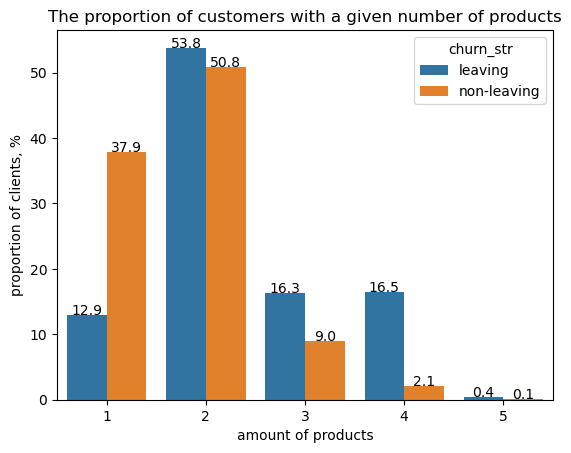

In [89]:
churn_bar(products_churn, products_churn['products'], products_churn['ratio'])
plt.ylabel('proportion of clients, %')
plt.xlabel('amount of products')
plt.title("The proportion of customers with a given number of products")
plt.show()

We see that there are differences among the leaving and non-leaving clients. In both groups, customers with 2 products are more likely to come across.
The share of non-leaving with 1 product is 38%, and among the leaving 13%. The shares of customers with 3 and 4 products among the leaving ones are 16% for both. There are few such clients among non-leaving ones - 9% and 2%, respectively.
Potentially, customers with 3 and 4 products are the weak part. Perhaps our bank is not yet so convenient for those who actively use banking products.

**Let's look at the property scores.**

In [90]:
equity_churn, equity_churn_1 = churn_groups(data, 'equity')

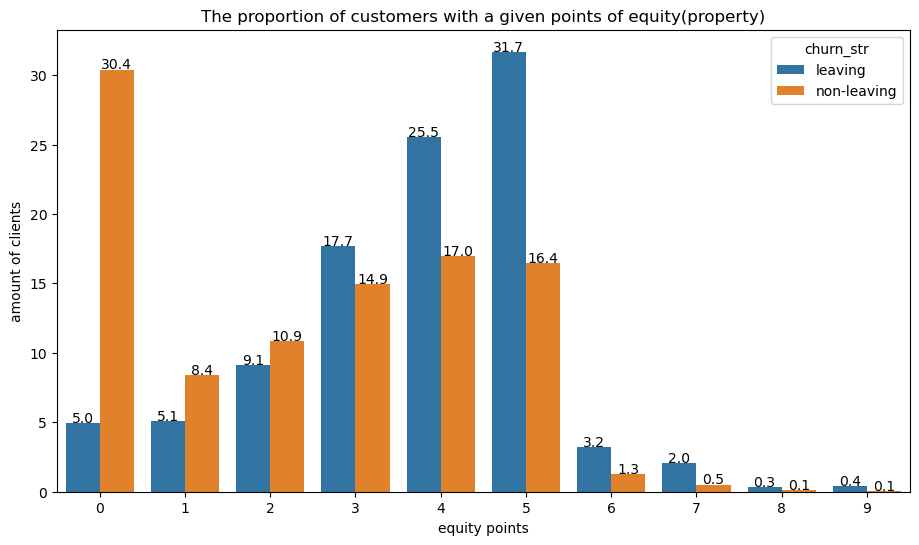

In [91]:
plt.figure(figsize=(11,6))
churn_bar(equity_churn, equity_churn['equity'], equity_churn['ratio'])
plt.ylabel('share of clients')
plt.xlabel('equity points')
plt.title("The proportion of customers with a given points of equity(property)")
plt.show()

There are also differences in property scores. Clients who are leaving most often have property points 3,4,5. While non-leaving clients in 30% of cases, i.e. most often, have 0 property points.
So wealthier people leave more often.
Among the non-leaving customers, the proportion of people with three or more products is less than among the leaving ones.

**Credit card.**

In [92]:
credit_churn, credit_churn_1 = churn_groups(data, 'credit_card')
#credit_churn

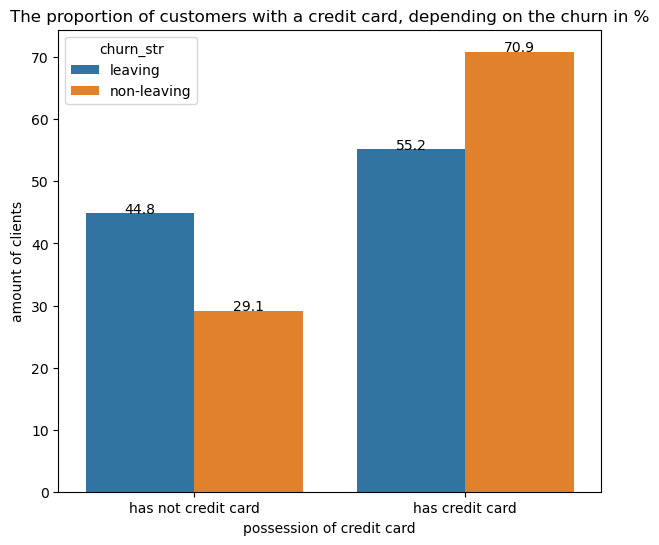

In [93]:
credit_churn # = credit_churn[credit_churn['credit_card']==1]

plt.figure(figsize=(7, 6))
churn_bar(credit_churn, credit_churn['credit_card'], credit_churn['ratio'])
plt.ylabel('share of clients')
plt.xlabel('possession of credit card')
plt.title("The proportion of customers with a credit card, depending on the churn in %")
labels = ['has not credit card','has credit card']
plt.xticks([0,1], labels)
plt.show()

Among leaving customers, the share of those using a credit card is more than 55%. Among those who do not leave, the share is more than 70%.
Accordingly, about 45% of those who leave and almost 30% of those who do not leave do not have a credit card.

**Significant activity.**

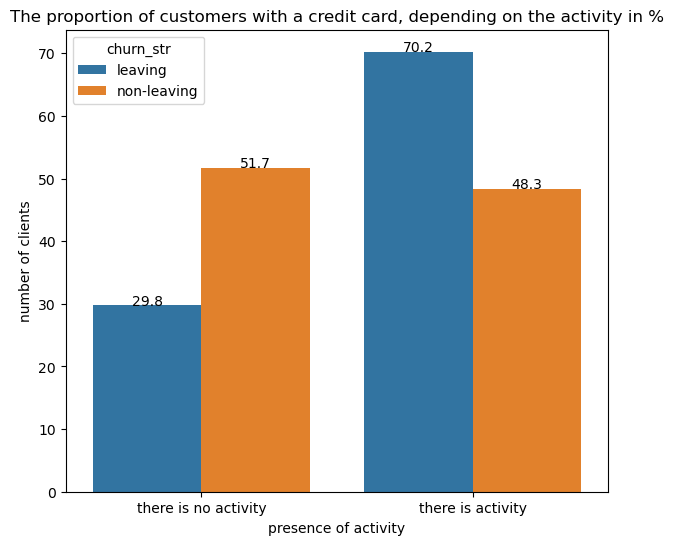

In [94]:
activity_churn, activity_churn_1 = churn_groups(data, 'last_activity')
activity_churn = activity_churn #[activity_churn['last_activity']==1]

plt.figure(figsize=(7, 6))
churn_bar(activity_churn, activity_churn['last_activity'], activity_churn['ratio'])
plt.ylabel('share of clients')
plt.xlabel('presence of activity')
plt.title("The proportion of customers with or without activity, depending on the churn, %")
labels = ['there is no activity','there is activity']
plt.xticks([0,1], labels)
plt.show()

Among those clients who leave, the proportion of people with activity is significantly higher. But it can also mean activity in connection with the closure of products, accounts, withdrawals of money.
For clients who do not leave, the shares of people with and without activity are approximately equal.

**Let's look at the proportion of leaving clients depending on gender.**

Let's add a column with the designation of the leaving and non-leaving clients.

In [95]:
data_initial['churn_str'] = data_initial['churn'].apply(churn_str)
#data_initial.head()

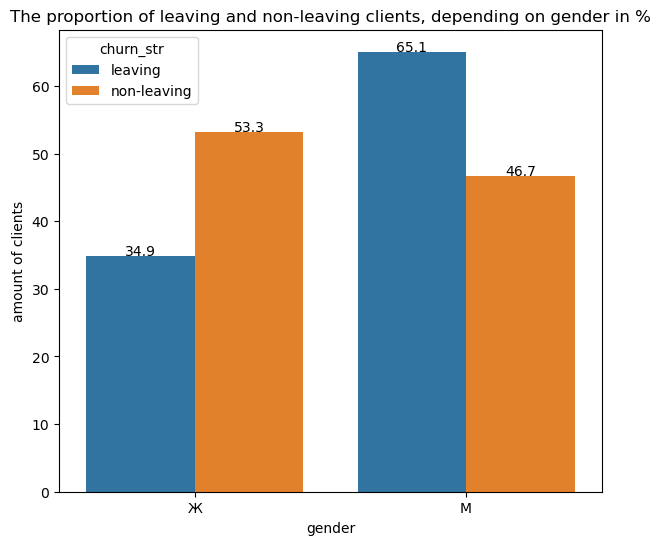

In [96]:
gender_churn, gender_churn_1 = churn_groups(data_initial, 'gender')

plt.figure(figsize=(7, 6))
churn_bar(gender_churn, gender_churn['gender'], gender_churn['ratio'])
plt.ylabel('share of clients')
plt.xlabel('gender')
plt.title("The proportion of leaving and non-leaving clients, depending on gender in %")
#plt.legend([],[], frameon=False)
plt.show()

It turns out that the proportion of woman is 53.3 among non-leaving clients, and 46.7 for men. Among leaving clients there is 65.1 men and 34.9 women.

**Let's look at the cities.**

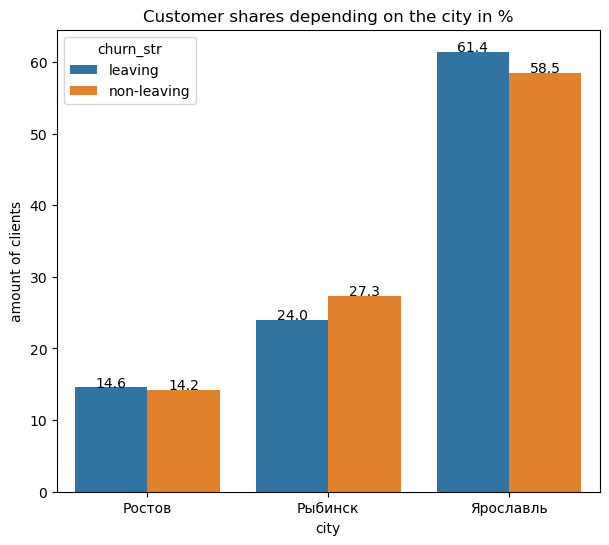

In [97]:
city_churn, city_churn_1 = churn_groups(data_initial, 'city')

plt.figure(figsize=(7, 6))
churn_bar(city_churn, city_churn['city'], city_churn['ratio'])
plt.ylabel('share of clients')
plt.xlabel('city')
plt.title("Customer shares depending on the city in %")
plt.show()

Since Yaroslavl has the more customers,there are the more leaving customers there.

**The result of the subsection. We can make a portrait of a typical leaving client.**

For balance and salary, let's take the median, for age and scoring points - the average. For the rest (categorical) - mode.

In [98]:
print(f'A typical outgoing client of our bank lives in Yaroslavl, has\
 age {round(description_table_1_churn.age[1],2)},\
 income {round(description_table_1_churn.est_salary_th[5],2)} th.rub. per month,\
 balance {round(description_table_1_churn.balance_th[5],2)} th.rub.')

A typical outgoing client of our bank lives in Yaroslavl, has age 41.43 years, income 125.41 th.rub. per month, balance 783.91 th.rub.


In [99]:
print("Usually it's a man.\
 More often, such client uses two banking products and has from 3 to 5 equity points, has a credit card.")

Usually it's a man. More often, such client uses two banking products and has from 3 to 5 equity points, has a credit card.


In [100]:
typical_churn_1=pd.DataFrame(
{"indicator":["age", "gender", "city", "salary, th.rub.", 
              "balance th.rub.", "prodcuts", "equity", "credit card", "activity"],
 "value":[41.43, "M", "Yaroslavl", 125.41, 783.91, 2, "from 3 to 5", "there is", "there is not"]})
typical_churn_1

,показатель,значение
0,age,41.43
1,gender,M
2,city,Yaroslavl
3,"salary, th.rub.",125.41
4,balance th.rub.,783.91
5,prodcuts,2
6,equity,from 3 to 5
7,credit card,there is
8,activity,there is not


**We can similarly build a portrait of a typical non-outgoing client.**

In [101]:
print(f'A typical non-leaving client of our bank lives in Yaroslavl, has\
 age {round(description_table_0_churn.age[1],2)} года,\
 income {round(description_table_0_churn.est_salary_th[5],2)} th.rub.,\
 balance on account {round(description_table_0_churn.balance_th[5],2)} th.rub.')

A typical non-leaving client of our bank lives in Yaroslavl, has age 43.02 года, income 118.25 th.rub., balance on account 475.35 th.rub.


In [102]:
print("Usually it's a man.\
 More often, such client uses two banking products and has 0 equity points, has a credit card.")

Usually it's a man. More often, such client uses two banking products and has 0 equity points, has a credit card.


In [103]:
typical_churn_0=pd.DataFrame(
{"indicator":["age", "gender", "city", "salary, th.rub.", 
              "balance, th.rub.", "products", "equity", "credit card", "activity"],
 "value":[43.02, "F", "Yaroslavl", 118.25, 475.35, 2, 0, "there is", "No"]})
typical_churn_0

,показатель,значение
0,age,43.02
1,gender,F
2,city,Yaroslavl
3,"salary, th.rub.",118.25
4,"balance, th.rub.",475.35
5,products,2
6,equity,0
7,credit card,there is
8,activity,No


## Ranges of indicators with the largest outflow of customers

### Let's start with categorical variables

**Products**.

We can create a function that will help us collect data to draw a graph with the shares of leaving customers for each attribute.

In [104]:
def high_churn (df, column):
    churn_groups = df[df['churn']==1].groupby([column,'churn'])['user_id'].count().reset_index()
    churn_groups['sum'] = 0

    for idx, value in enumerate(churn_groups['sum']):
        churn_groups['sum'][idx]=df[df[column]==churn_groups[column][idx]]['user_id'].count()
        
    churn_groups['ratio'] = round(churn_groups['user_id'] / churn_groups['sum']*100)
    return churn_groups

In [105]:
churn_groups = high_churn(data, 'products')
#churn_groups

Let's create a function for drawing the graph.

In [106]:
def churn_bar (df, x_axis, y_axis):
    ax = sns.barplot(
    data=df, x=x_axis, 
    y=y_axis)

    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.1f}'.format(height), 
        ha = 'center') 
    return ax

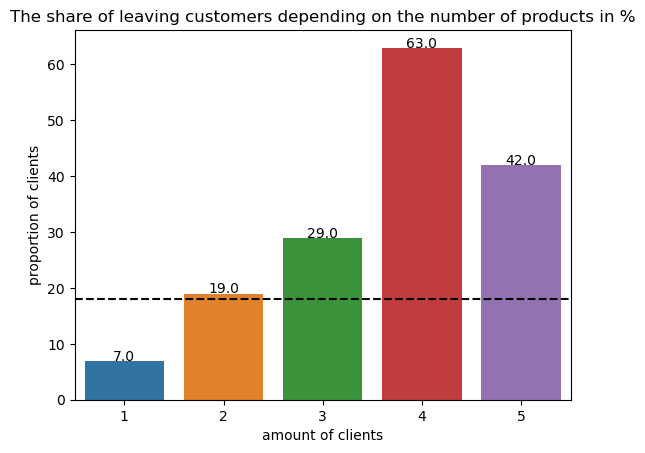

In [107]:
churn_bar(churn_groups, 'products', 'ratio')
plt.ylabel('proportion of clients')
plt.xlabel('amount of clients')
plt.title("The share of leaving customers depending on the number of products in %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

The dotted line shows the average level of outflow according to the data as a whole. We see that customers with 2,3,4,5 products exceed the average values. Perhaps our bank is not yet so convenient for those who actively use banking products. Let's see how much the difference between the proportion of customers with 2 products and the average dataset is statistically significant.

Null hypothesis: There is no statistically significant difference between the proportion of leaving customers with 2 products and the average proportion of leaving customers.\
Alternative hypothesis: there is a statistically significant difference.\
Let's write the function for the z-test for proportions.

In [108]:
def proportion_z_test (data, column, variable):
    variable_churn = data.loc[(data[column]==variable)&(data['churn']==1)]["user_id"].count()
    variable_total = data[data[column]==variable]["user_id"].count()
    all_churn = data.loc[data['churn']==1]["user_id"].count()
    all_data = data["user_id"].count()
    
    alpha = 0.05
    count = [variable_churn, all_churn]
    nobs = [variable_total, all_data]
    stat, p_value = proportions_ztest(count, nobs)

    print('p-value: ', p_value)

    if p_value < alpha: 
        print('We reject the null hypothesis: there is a significant difference between the proportions.')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different.')

In [109]:
proportion_z_test (data, 'products', 2)

p-value:  0.19349933239685313
It was not possible to reject the null hypothesis, there is no reason to consider the shares different.


It turns out that there are serious differences with the average value only in groups of customers with 3,4,5 products.

**We will do the same analysis for property points.**.

In [110]:
churn_groups = high_churn(data, 'equity')
#churn_groups

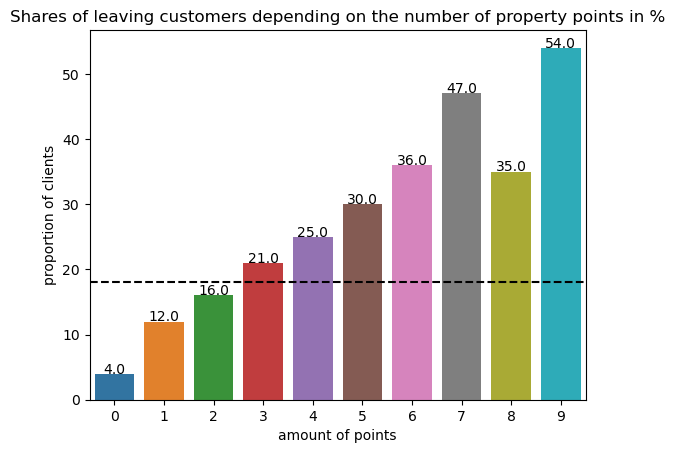

In [111]:
churn_bar(churn_groups, 'equity', 'ratio')

plt.ylabel('proportion of clients')
plt.xlabel('amount of points')
plt.title("Shares of leaving customers depending on the number of property points in %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

The dotted line shows the average level of outflow according to the data as a whole. We see that customers with 3 or more points exceed the average. Perhaps our bank is not so convenient for wealthier clients yet. Let's see how much the difference between the proportion of customers with 3 points and the average for the dataset is statistically significant.

Null hypothesis: there is no statistically significant difference between the proportion of leaving customers with 3 points and the average proportion of leaving customers.\
Alternative hypothesis: there is a statistically significant difference.

In [112]:
proportion_z_test (data, 'equity', 3)

p-value:  0.013489838514100204
We reject the null hypothesis: there is a significant difference between the proportions.


It turns out that customers with 3 points have a significantly higher share of churn. Customers with even higher scores have even bigger outflows.

**Now cities.**

In [113]:
churn_groups = high_churn(data_initial, 'city')
#churn_groups

C:\Users\User\AppData\Local\Temp\ipykernel_20252\2873691376.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_groups['sum'][idx]=df[df[column]==churn_groups[column][idx]]['user_id'].count()


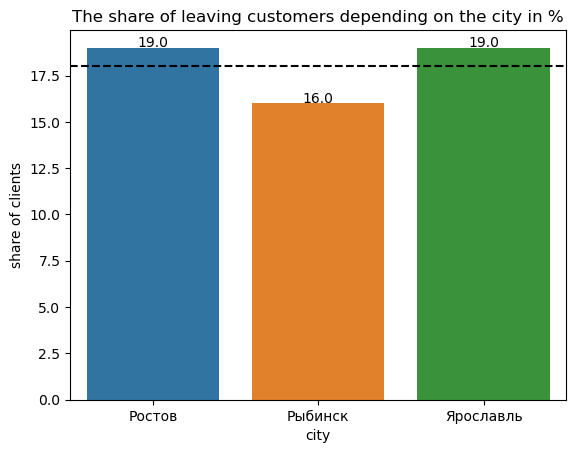

In [114]:
churn_bar(churn_groups, 'city', 'ratio')

plt.ylabel('share of clients')
plt.xlabel('city')
plt.title("The share of leaving customers depending on the city in %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

The dotted line shows the average level of outflow according to the data as a whole. We see that clients from Rostov and Yaroslavl slightly exceed the average values. But it is not enough for them to form a category of customers with a very strong outflow.

**Gender.**

In [115]:
churn_groups = high_churn(data_initial, 'gender')
#churn_groups

C:\Users\User\AppData\Local\Temp\ipykernel_20252\2873691376.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_groups['sum'][idx]=df[df[column]==churn_groups[column][idx]]['user_id'].count()


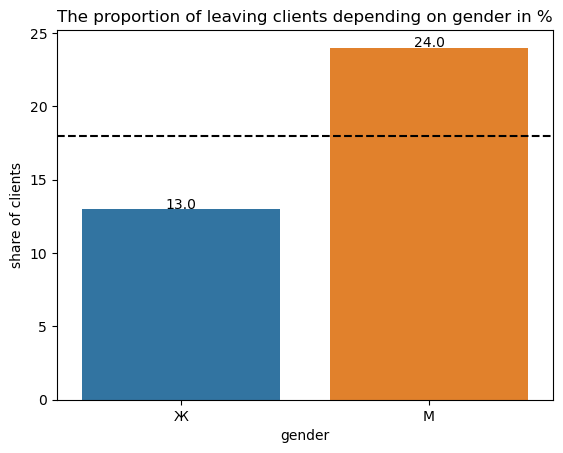

In [116]:
churn_bar(churn_groups, 'gender', 'ratio')

plt.ylabel('share of clients')
plt.xlabel('gender')
plt.title("The proportion of leaving clients depending on gender in %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
plt.show()

The share of leaving clients among men exceeds the average of 18%. Let's find out how statistically significant this is.

Null hypothesis: there is no statistically significant difference between the proportion of leaving clients among men and the average proportion of leaving clients.\
Alternative hypothesis: there is a statistically significant difference.

In [117]:
proportion_z_test (data_initial, 'gender', 'М')

p-value:  3.8070327817630806e-15
We reject the null hypothesis: there is a significant difference between the proportions.


The difference is significant and it can be assumed that there are significantly more men who are ready to leave the bank than on average.

**Now with credit cards.**

In [118]:
churn_groups = high_churn(data, 'credit_card')
churn_groups

,credit_card,churn,user_id,sum,ratio
0,0,1,815,3174,26.0
1,1,1,1003,6748,15.0


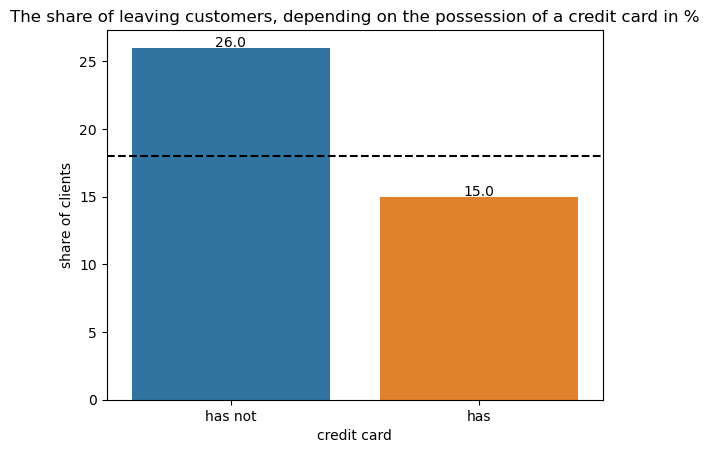

In [119]:
churn_bar(churn_groups, 'credit_card', 'ratio')

plt.ylabel('share of clients')
plt.xlabel('credit card')
plt.title("The share of leaving customers, depending on the possession of a credit card in %")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
labels = ['has not','has']
plt.xticks([0,1], labels)
plt.show()

In [120]:
print(f'We see that people without a credit card are approximately\
 {round(churn_groups.ratio[0]/(data.churn.mean()*100),2)} times more often than in average are ready to leave.')

We see that people without a credit card are approximately 1.42 times more often than in average are ready to leave.


**Now for significant activity.**

In [121]:
churn_groups = high_churn(data, 'last_activity')
churn_groups

,last_activity,churn,user_id,sum,ratio
0,0,1,541,4729,11.0
1,1,1,1277,5193,25.0


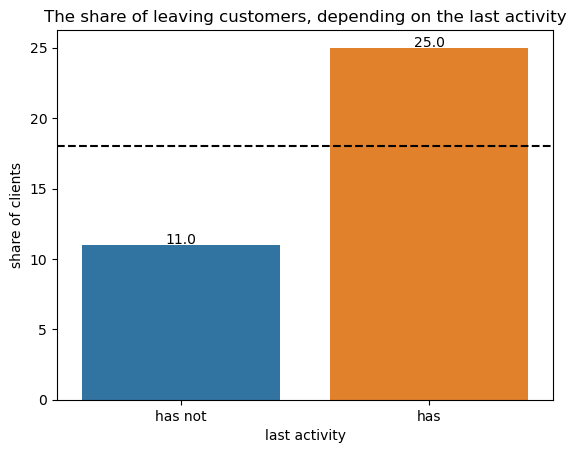

In [122]:
churn_bar(churn_groups, 'last_activity', 'ratio')

plt.ylabel('share of clients')
plt.xlabel('last activity')
plt.title("The share of leaving customers, depending on the last activity")
plt.axhline(y=round(data.churn.mean()*100), color='black', linestyle='--')
labels = ['has not','has']
plt.xticks([0,1], labels)
plt.show()

In [123]:
print(f'We see that people with recent significant acitvity\
 {round(churn_groups.ratio[1]/(data.churn.mean()*100),2)} times more often than in average are ready to leave.')

We see that people with recent significant acitvity 1.36 times more often than in average are rady to leave.


**Intermediate conclusion. It is possible to identify the most problematic areas for different indicators.**

* Customers with 3,4,5 products exceed the average value of the dataset by at least 1.6 times.
* Customers with 3 property points have a 16% higher churn rate than the average. Customers with 4 points 38% higher. 
* Customers with an even higher number of points by at least 66%, depending on the points.
* Every city is very close to the average, there are no significant differences.
* The share of leaving clients among men exceeds the average of 18%.
* People without a credit card are about 1.42 times more likely to leave.
* People with recent significant activity are about 1.36 times more likely than average to be close to leaving the bank.

### Comparing the distributions of probability densities of continuous features: salary and balance

Salary and balance we will analyze in th.rubles.\
**Let's start with the salary.**

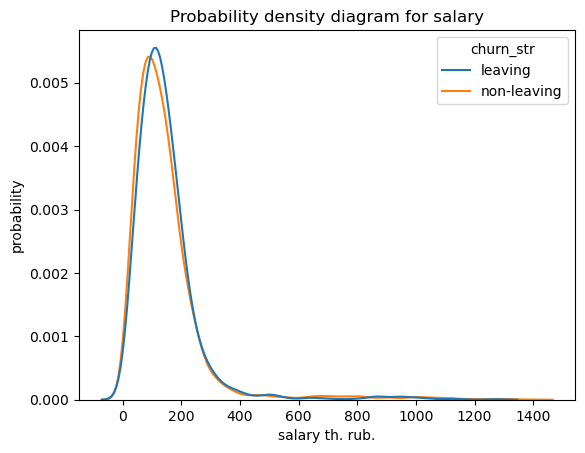

In [124]:
sns.kdeplot(data=data, x='est_salary_th', common_norm=False, hue='churn_str')
plt.title('Probability density diagram for salary')
plt.ylabel('probability')
plt.xlabel('salary th. rub.')
plt.show()

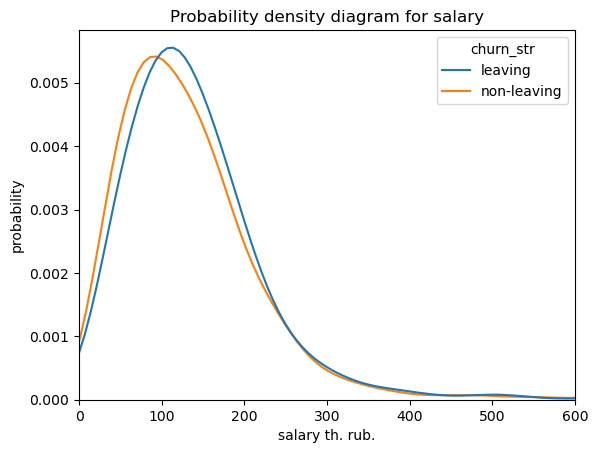

In [125]:
sns.kdeplot(data=data, x='est_salary_th', common_norm=False, hue='churn_str')
plt.title('Probability density diagram for salary')
plt.ylabel('probability')
plt.xlabel('salary th. rub.')
plt.xlim(0, 600)
plt.show()

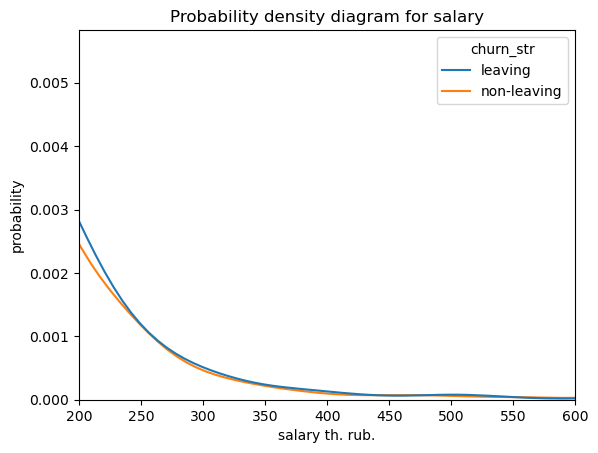

In [126]:
sns.kdeplot(data=data, x='est_salary_th', common_norm=False, hue='churn_str')
plt.title('Probability density diagram for salary')
plt.ylabel('probability')
plt.xlabel('salary th. rub.')
plt.xlim(200, 600)
plt.show()

The chart for leaving clients is shifted slightly to the right. Based on this, three groups of customers can be distinguished:

* Customers with a salary of up to 100 th. whose outflow probabilities are lower than the average for the dataset.
* Customers with a salary from 100 to 250 th.rub. who have higher outflow probabilities than the average for the dataset.
* Clients with a salary of 250 th.rub. and above who have an outflow probability approximately equal for the outflow and non-outflow.
It turns out that the problem area is customers with a salary from 100 to 250 tr.

**Let's study the distributions for the balance.**

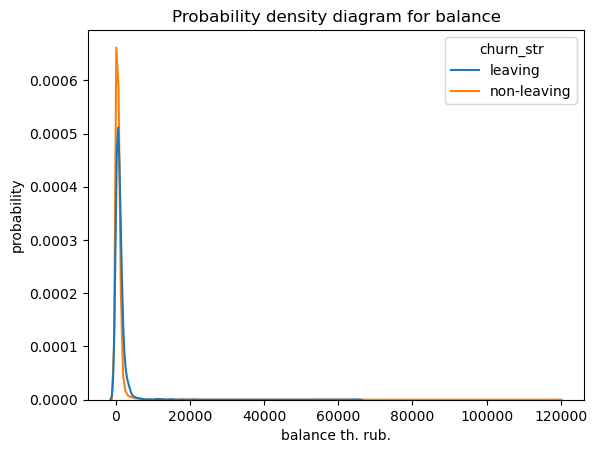

In [127]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Probability density diagram for balance')
plt.ylabel('probability')
plt.xlabel('balance th. rub.')
plt.show()

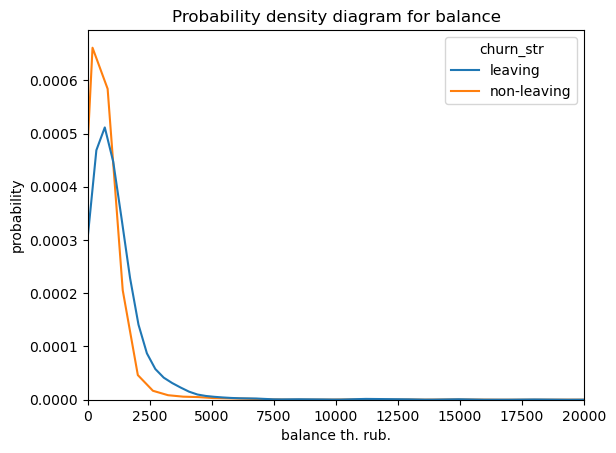

In [128]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Probability density diagram for balance')
plt.ylabel('probability')
plt.xlabel('balance th. rub.')
plt.xlim(0, 20000)
plt.show()

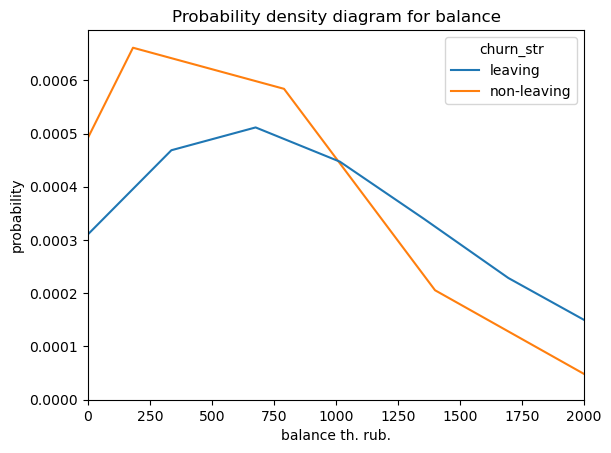

In [129]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Probability density diagram for balance')
plt.ylabel('probability')
plt.xlabel('balance th. rub.')
plt.xlim(0, 2000)
plt.show()

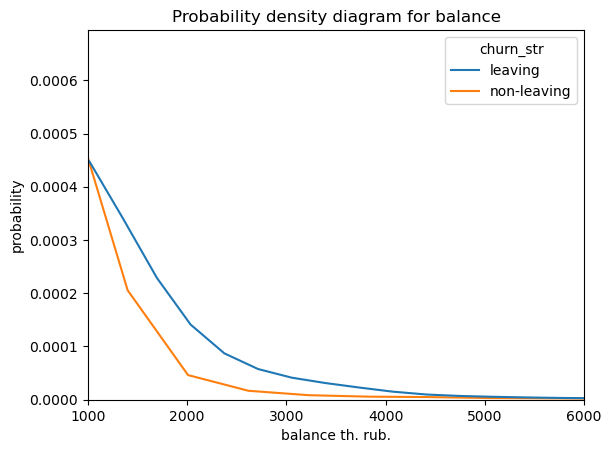

In [130]:
sns.kdeplot(data=data, x='balance_th', common_norm=False, hue='churn_str')
plt.title('Probability density diagram for balance')
plt.ylabel('probability')
plt.xlabel('balance th. rub.')
plt.xlim(1000, 6000)
plt.show()

The chart for leaving customers has higher values on the right. Based on this, two groups of customers can be distinguished:
* Clients with a balance of up to 1 million rubles, whose outflow probabilities are lower than the average for the dataset.
* Clients with a balance from 1 million rubles to 4.5 million rubles, whose outflow probabilities are higher than the average for the dataset.
* Customers with a balance of 4.5 million rubles, who have the probability of outflow as an average for the dataset.

**Conclusion to the subsection. It is possible to distinguish such problematic intervals for signs.**

* On the basis of salary, the problem area is customers with a salary from 100 to 250 th.rub.
* Based on the balance, problem area are clients with a balance from 1 million rubles to 4.5 million rubles.

Such people aren't very rich, but they have capital and an income above average, which means they actively use banking products. For example, cashbacks, accumulation of miles for purchases, interest income on the balance on a bank account, they definitely use savings accounts, deposits.
They may be interested in insurance products, for example, travel insurance, property insurance, including car and real estate.

### Comparing the density distributions of discrete features: credit scoring score and age

**Let's start with age**.

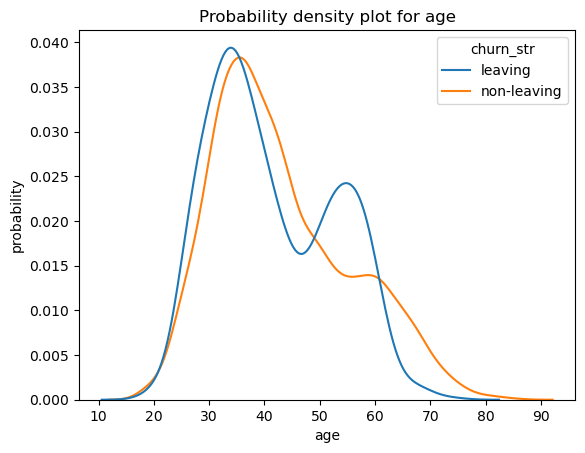

In [131]:
sns.kdeplot(data=data, x='age', common_norm=False, hue='churn_str')
plt.title('Probability density plot for age')
plt.ylabel('probability')
plt.xlabel('age')
plt.show()

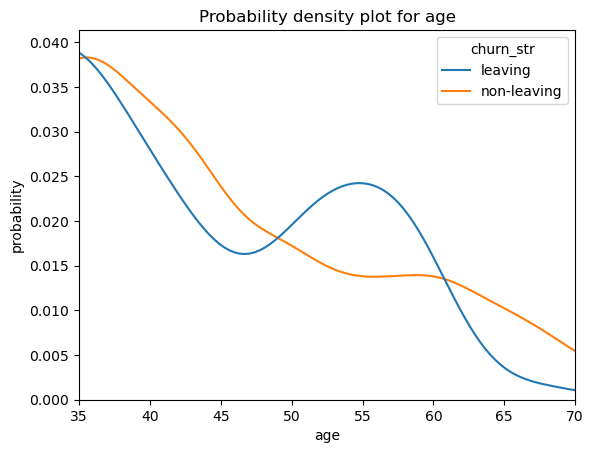

In [132]:
sns.kdeplot(data=data, x='age', common_norm=False, hue='churn_str')
plt.title('Probability density plot for age')
plt.ylabel('probability')
plt.xlabel('age')
plt.xlim(35, 70)
plt.show()

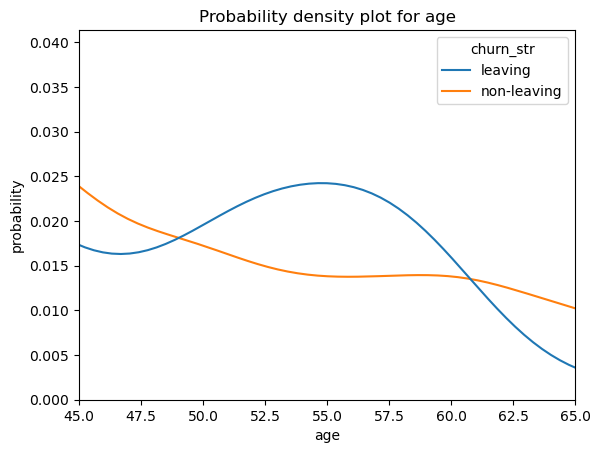

In [133]:
sns.kdeplot(data=data, x='age', common_norm=False, hue='churn_str')
plt.title('Probability density plot for age')
plt.ylabel('probability')
plt.xlabel('age')
plt.xlim(45, 65)
plt.show()

We can divide the data into several groups:
* Clients under 35 are more likely to plan to leave the bank than the average according to all data.
* Customers aged 35 to 49 are less likely than the average to leave the bank.
* Customers from 49 to 61 years old are not loyal.
* Customers older than 61 are more likely not to leave than the average for the dataset.

**Now the credit scoring points.**.

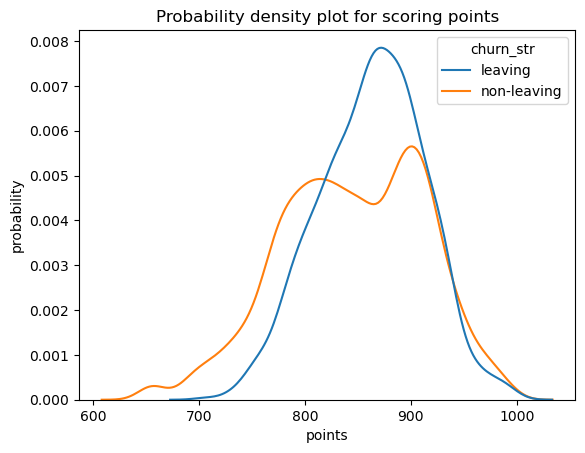

In [134]:
sns.kdeplot(data=data, x='score', common_norm=False, hue='churn_str')
plt.title('Probability density plot for scoring points')
plt.ylabel('probability')
plt.xlabel('points')
plt.show()

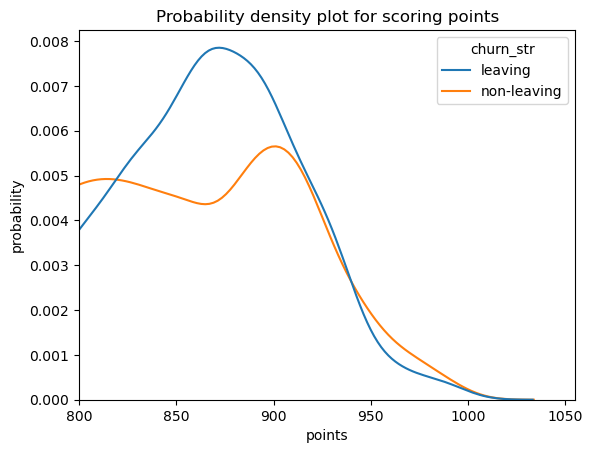

In [135]:
sns.kdeplot(data=data, x='score', common_norm=False, hue='churn_str')
plt.title('Probability density plot for scoring points')
plt.ylabel('probability')
plt.xlabel('points')
plt.xlim(800)
plt.show()

We can divide the data into several groups:

* Customers who have up to 820 points less often tend to leave the bank than the average according to the data.
* Customers who have from 820 points to 930 points more often than the average plan to leave the bank.
* Customers who have 930  and more points less than the average are ready to leave the bank.

**Conclusion to the subsection. It is possible to distinguish problematic intervals for score and age.**


* Based on age, the problem areas are clients under 35 and from 49 to 61.
* On the basis of credit scoring points, the problem area is customers who have from 820 to 930 points.

If we combine it with the conclusions to the subsection with the salary and balance, then customers with an age of up to 35 may be interested in cashback cards, accumulation of miles, some investment products.
People from 49 to 61 years old may be interested in some family service packages in the bank, including insurance for family members, perhaps debit cards for all family members tied to one bank account.

### Let's compare the average values for leaving and non-leaving features for continuous and discrete variables

**Salary.**

In [136]:
data.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,rostov,rybinsk,yaroslavl,female,male,est_salary_th,balance_th,churn_str
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,0,1,0,1,0,75.71914,59.21482,leaving
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,0,1,0,1,0,86.62177,850.59433,non-leaving
2,120722,892.0,30.0,0,NaN,1,1,1,107683.34,0,1,0,1,0,1,0,107.68334,NaN,non-leaving
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,0,1,1,0,174.42353,1524.74626,leaving
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,0,1,0,1,67.35316,0.17400,leaving


We have a problem group - these are leaving clients with a salary from 100 to 250 th.rub. Let's look at their average, the general average and the average among the leaving clients.

We can create a function that will make a table with 4 values:
* the average value for non-leaving;
* the average of the leaving; 
* average for the problem group among the leaving;
* average for the leaving with the exception of the problem group.

In [137]:
def mean_comparison (column, number_1, number_2):
    
    no_churn_mean = data[data['churn']==0][column].mean()
    
    churn_mean = data[data['churn']==1][column].mean()
    
    problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)]
    problem = problem[problem["churn"]==1][column].mean()
    
    no_problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)][column]
    no_problem = data[~data[column].isin(no_problem)]
    churn_no_problem = no_problem[no_problem["churn"]==1][column].mean()
    
    mean = pd.DataFrame(
    {'indicator':['non-leaving average', 'leaving average', 
               'average for the problem group among the leaving',\
                   'average for the leaving with the exception of the problem group.'],
     'value':[no_churn_mean, churn_mean, problem, churn_no_problem]})
    
    plt.figure(figsize=(11,6))
    ax = sns.barplot(
    data = mean, x='indicator', y='value')
    for p in ax.patches:
        height = p.get_height() 
        ax.text(x = p.get_x()+(p.get_width()/2), 
        y = height+0.05, 
        s = '{:.1f}'.format(height), 
        ha = 'center')

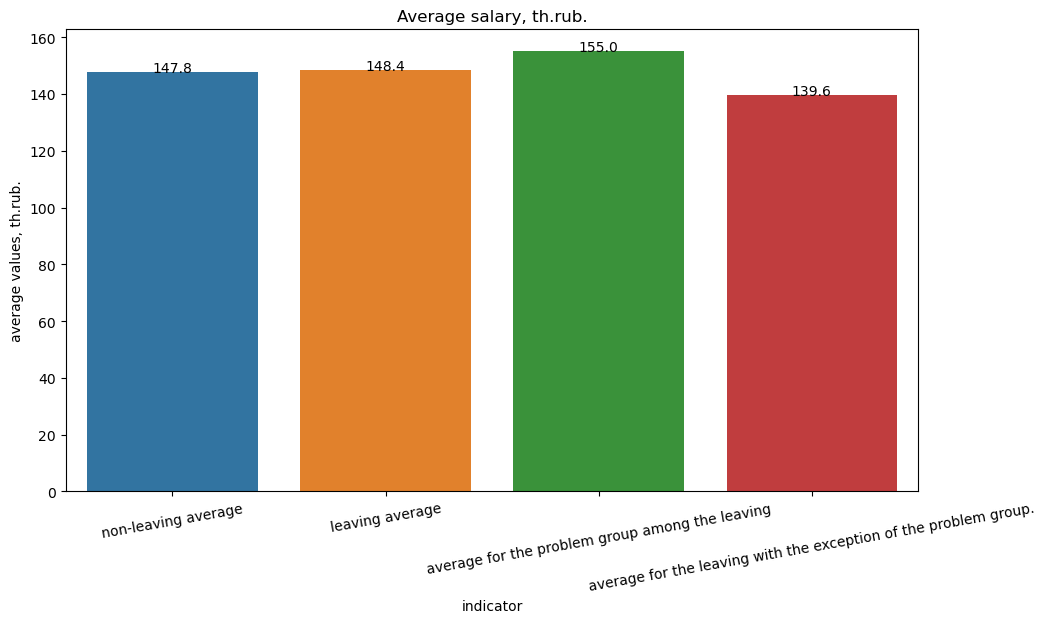

In [138]:
mean_comparison('est_salary_th', 100, 250)
plt.ylabel('average values, th.rub.')
plt.title("Average salary, th.rub.")
plt.xticks(rotation=10)
plt.show()

The difference between the values is low, so it is impossible to say without a test that we can clearly identify the leaving ones by the salary. We will compare the average of the leaving with the non-leaving. And also the average for the problematic leaving with the rest of the leaving.

**Now let's calculate for the balance.**

On the basis of the balance, the problem area is high-quality customers with a balance from 1 million rubles to 4.5 million rubles. Let's look at the average balance for this area, as well as the overall average balance and the average balance among the high-quality ones.

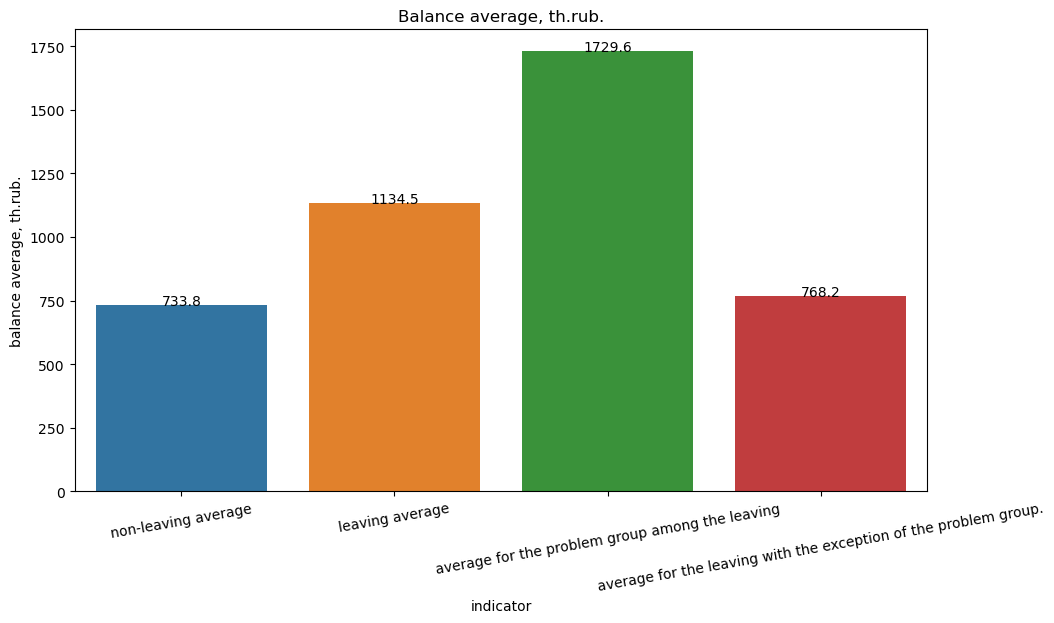

In [139]:
mean_comparison('balance_th', 1000, 4500)
plt.ylabel('balance average, th.rub.')
plt.title("Balance average, th.rub.")
plt.xticks(rotation=10)
plt.show()

In [229]:
print(f'Average balance for leaving clients is bigger than for non-leaving\
  {round(1134.5/733.8,2)} times. For leaving clients with balance from 1 to 4.5 mln. an average is\
 {round(1729.6/768.2,2)} times bigger, than for other leaving clients.')

Average balance for leaving clients is bigger than for non-leaving  1.55 times. For leaving clients with balance from 1 to 4.5 mln. an average is 2.25 times bigger, than for other leaving clients.


There is a big difference in all values. There is a particularly big difference between the average outgoing customers with a balance from 1 to 4.5 million rubles and the rest of the outgoing ones. This means that outgoing customers with a balance from 1 to 4.5 million rubles are a sign that well characterizes people who can leave the bank.

**Now let's calculate for scoring estimates.**

On the basis of credit scoring points, the problem area is customers who have from 820 to 930 points.

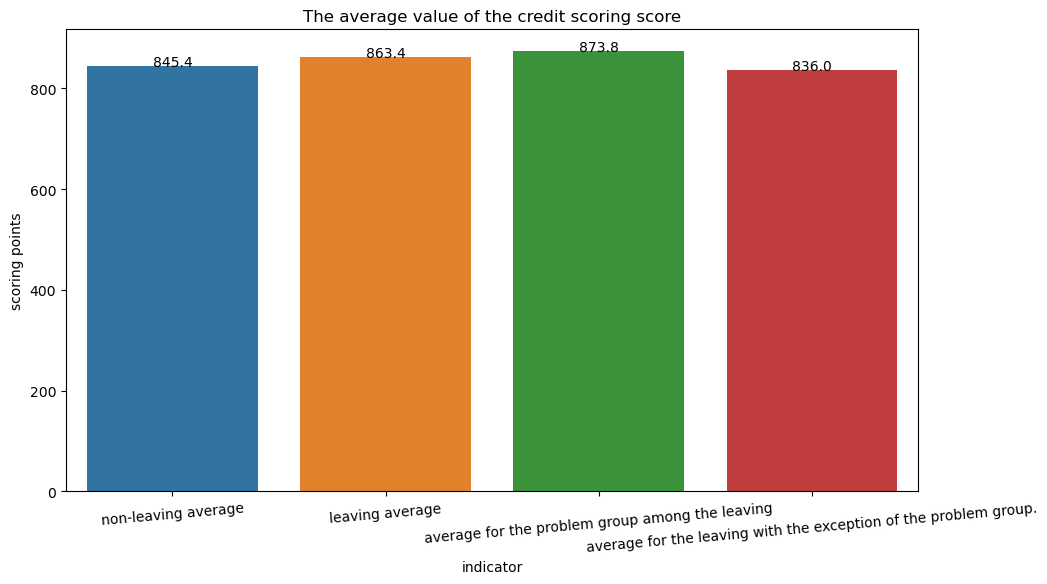

In [141]:
mean_comparison('score', 820, 930)
plt.ylabel('scoring points')
plt.title("The average value of the credit scoring score")
plt.xticks(rotation=5)
plt.show()

In [230]:
print(f'Average scoring points for leaving clients are higher than for non-leaving\
 average {round(863.4/845.4,2)} times. For leaving clients with scores 820-930 average is\
 {round(873.8/863,2)} times bigger than for other leaving clients.')

Average scoring points for leaving clients are higher than for non-leaving average 1.02 times. For leaving clients with scores 820-930 average is 1.01 times bigger than for other leaving clients.


The difference is minimal. It will be necessary to further test the hypothesis whether the average scoring score for those who are leaving with a score of 820-930 differs significantly from the average score for the rest of those who are leaving. If it is significant, then we can assume that this is an important feature that characterizes high-quality customers. If not, then this sign will not tell us whether the client is a good customer or not.

**Age.**

Based on age, the problem areas are clients under 35 and from 49 to 61. We have two problem areas here, so the previous function won't work.

In [143]:
no_churn_mean = data[data['churn']==0]['age'].mean()
churn_mean = data[data['churn']==1]['age'].mean()

problem_1 = data.query('age<=35 and churn==1')['age'].mean()
problem_2 = data.query('49<=age<=61 and churn==1')['age'].mean()

no_problem_1 = data.loc[data['age']<=35]['age']
no_problem_1 = data[~data['age'].isin(no_problem_1)]
churn_no_problem_1 = no_problem_1[no_problem_1["churn"]==1]['age'].mean()

no_problem_2 = data.loc[(data['age']<=61)&(data['age']>=49)]['age']
no_problem_2 = data[~data['age'].isin(no_problem_2)]
churn_no_problem_2 = no_problem_2[no_problem_2["churn"]==1]['age'].mean()

mean_1 = pd.DataFrame(
    {'indicator':['non-leaving average', 'leaving average'],
     'value':[no_churn_mean, churn_mean]})

mean_2 = pd.DataFrame(
    {'indicator':['average for leaving aged less than 35 incl.', 'average for leaving aged 49-61 incl.',
               'average for leaving aged 35+', 'average for leaving aged leass than 49 and 61+'],
     'value':[problem_1, problem_2, churn_no_problem_1, churn_no_problem_2]})

In [144]:
display(mean_1)
mean_2

,indicator,value
0,non-leaving average,43.016288
1,leaving average,41.429593


,indicator,value
0,average for leaving aged less than 35 incl.,30.439655
1,average for leaving aged 49-61 incl.,54.827853
2,average for leaving aged 35+,48.246881
3,average for leaving aged 49 and less and 61+,36.105304


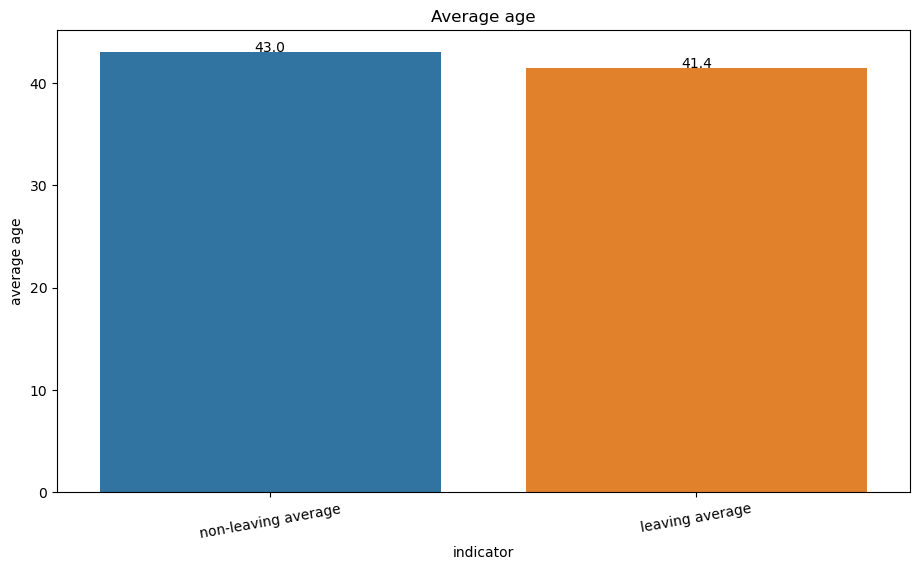

In [145]:
plt.figure(figsize=(11,6))
ax = sns.barplot(
data = mean_1, x='indicator', y='value')
for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center') 
    
plt.ylabel('average age')
plt.title("Average age")
plt.xticks(rotation=10)
plt.show()

It turns out that the difference between leaving and non-leaving is very small. It is necessary to check the significance of the test. Let's look at the averages of the problem groups.

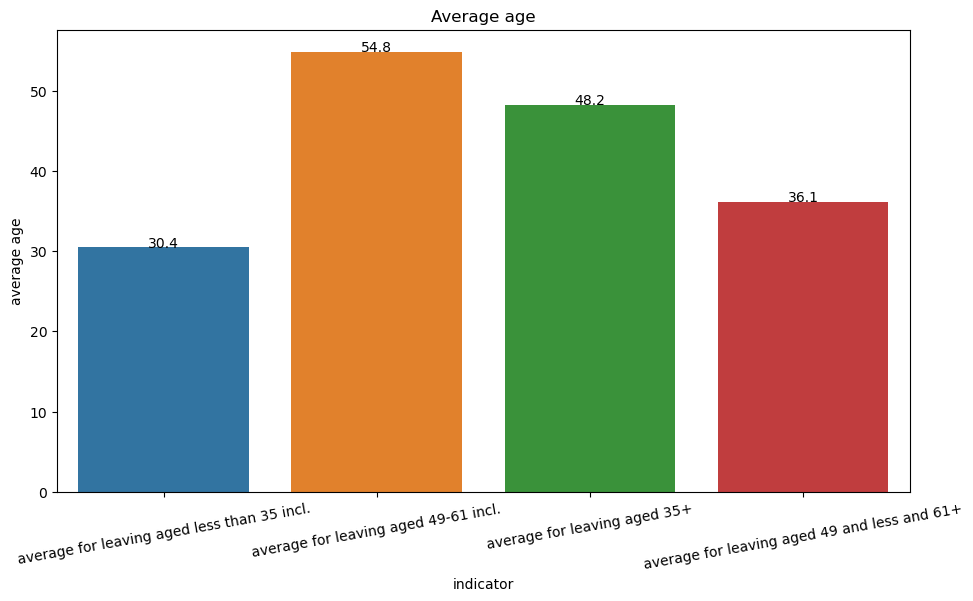

In [146]:
plt.figure(figsize=(11,6))
ax = sns.barplot(
data = mean_2, x='indicator', y='value')
for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.05, 
    s = '{:.1f}'.format(height), 
    ha = 'center') 
    
plt.ylabel('average age')
plt.title("Average age")
plt.xticks(rotation=10)
plt.show()

But the problematic age categories are quite far from the average of the rest of the leaving.
In particular, the average age of leaving less than 35 years is 1.59 times lower than the average age of leaving over 35 years.
The average of the leaving ones from 49 to 61 is 1.52 times higher than the average of the other leaving. Statistical tests are not needed for such differences.

## Correlations

Correlations of the "churn" column values with other columns using phik coefficient.

In [147]:
data_phik = data_initial.set_index("user_id")

# Deleting the previously added column that duplicates the original data
data_phik = data_phik.drop(columns = ['churn_str'],axis = 1)

In [148]:
interval_cols = ['score', 'age', 'balance', 'est_salary']

phik_overview = data_phik.phik_matrix(interval_cols=interval_cols)

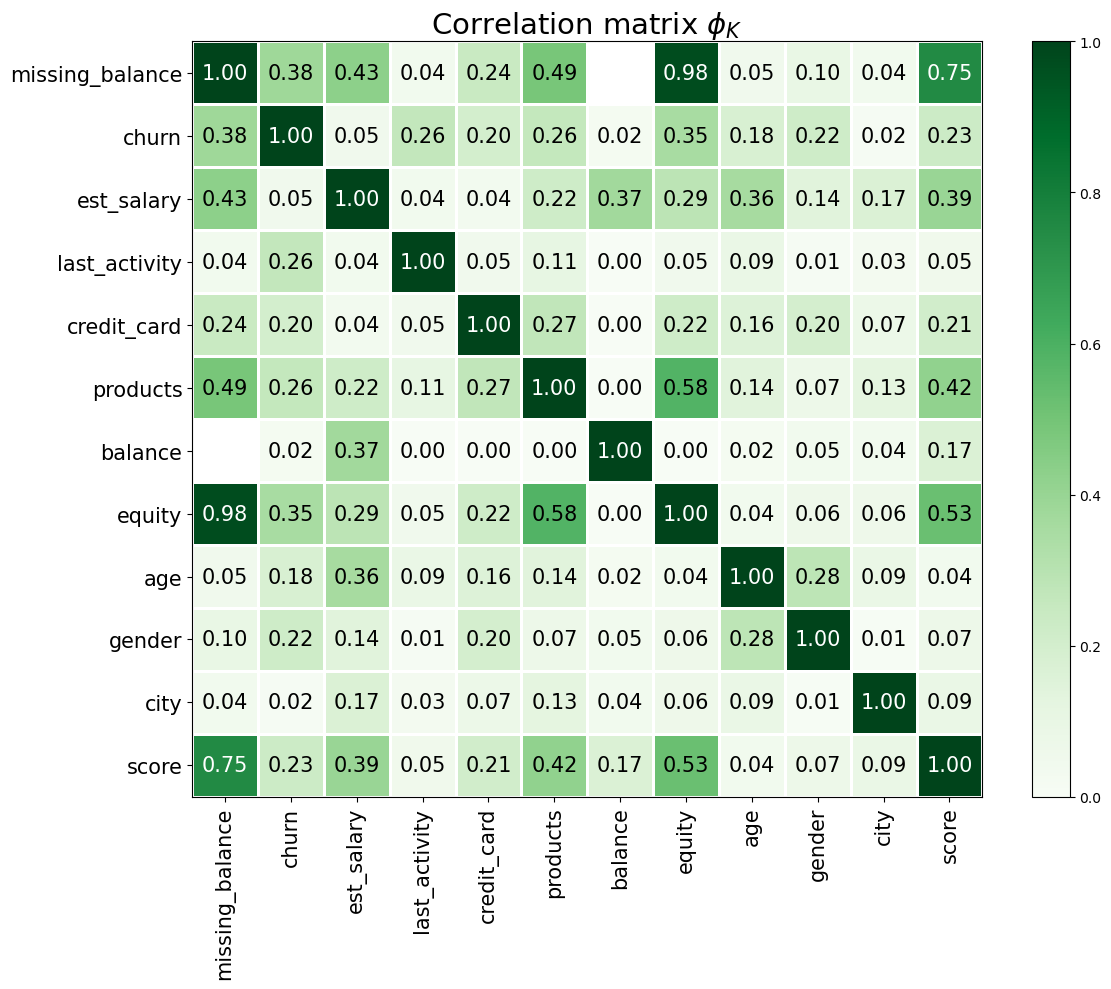

In [149]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Correlation matrix $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(12, 10))
plt.tight_layout()

In [150]:
From = 0.5
To = 10.5
Step = 1
ticks_position = np.arange(From, To, Step)
ticks_name =['city', 'balance', 'salary', 'age', 
        'credit card', 'gender', 'scoring score', 'quantity of products', 'last activity', 'equity points']
ticks_name=ticks_name[::-1]

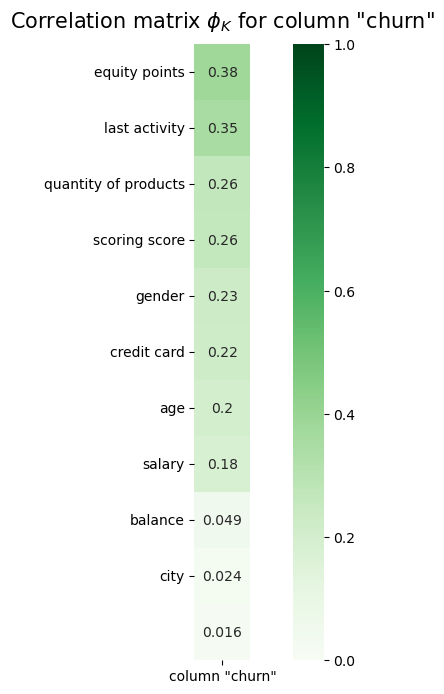

In [151]:
plt.figure(figsize=(11,8))
ax = sns.heatmap(phik_overview[['churn']].sort_values(by='churn', ascending=False).drop(labels = ['churn'],axis = 0),
    cmap="Greens", annot=True,
    vmin=0, vmax=1.0,
    square=True)
ax.set_title('Correlation matrix $\phi_K$ for column "churn"', fontdict={'fontsize':15}, pad=12)
plt.yticks(ticks_position, ticks_name)
plt.xticks([0.5],['column "churn"'])
plt.show()

We should delet duplicated values in matrix.

In [152]:
mask = np.zeros_like(phik_overview, dtype=bool)
mask[np.triu_indices_from(mask)] = True
phik_overview[mask] = np.nan

In [153]:
phik_overview = phik_overview.drop(['score'], axis=0).drop(['churn'], axis=1)

In [154]:
x_ticks_name=['scoring', 'city', 'gender', 'age', 'property', 
        'balance', 'quantity of products', 'credit card', 'activity', 'salary']
y_ticks_name=['city', 'gender', 'age', 'equity', 
        'balance', 'quantity of products', 'credit card', 'activity', 'salary', 'churn']

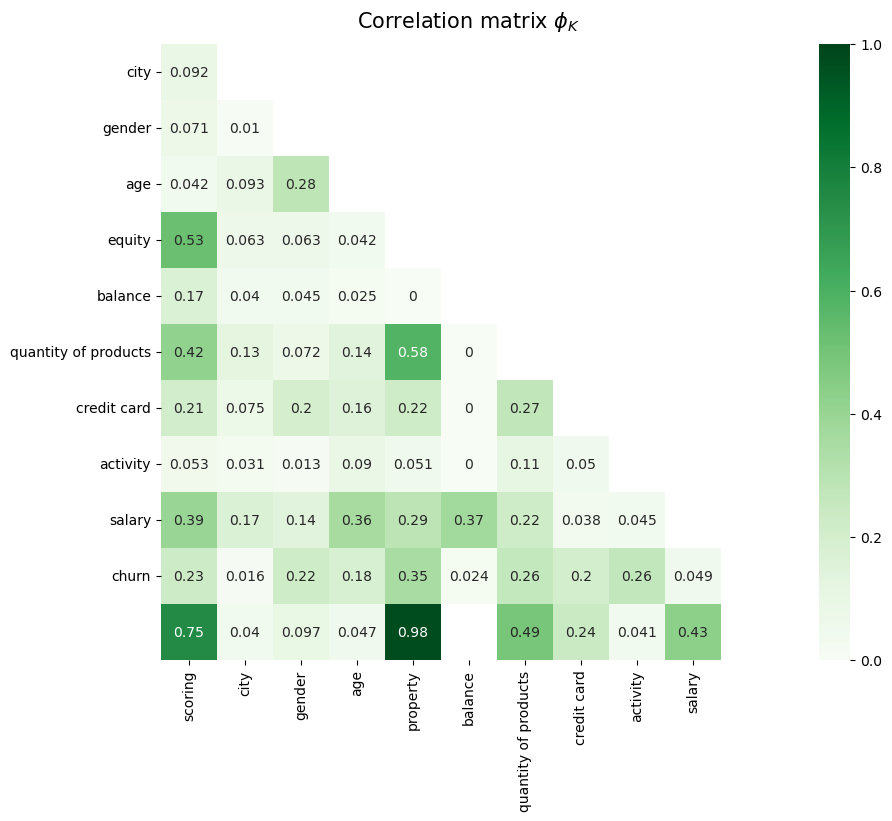

In [155]:
plt.figure(figsize=(11,8))
ax = sns.heatmap(phik_overview,
    cmap="Greens", annot=True,
    vmin=0, vmax=1.0,
    square=True, yticklabels=y_ticks_name, xticklabels=x_ticks_name)
ax.set_title('Correlation matrix $\phi_K$', fontdict={'fontsize':15}, pad=12)
plt.show()

We see that the outflow/non-outflow column has the greatest relationship with property points.\
Also above 0.1 is the relationship with scoring score, gender, age, number of products, credit card availability, recent activity.\
Scoring evaluation is a certain algorithm, if it includes similar parameters as the churn assessment, then this may also be due to the relationship of these columns.

## Conclusions to the section

* Customers with 3,4,5 products seriously exceed the average value of the dataset by at least 1.6 times.
* Customers with 3 property points have a 16% higher churn rate than the average. Customers with 4 points churn rate is 38% higher. 
* Customers with an even higher number of points by at least 66%, depending on the points.
* Every city is very close to the average, there are no significant differences.
* The share of leaving clients among men exceeds the average by 18%.
* People without a credit card are about 1.42 times more likely to be outgoing.
* People with recent significant activity are about 1.36 times more likely than average to be close to leaving the bank.

* On the basis of salary, the problem area is customers with salary from 100 to 250 th.
Nevertheless, the average salaries of the problematic area among leaving and the rest of the leaving are very close to each other. We need to check the significance of the differences.

* On the basis of the balance, problem area is customers with a balance from 1 million rubles to 4.5 million rubles
The average balance among leaving customers is 1.55 times higher than the average for non-leaving customers. For leaving clients with a balance from 1 to 4.5 million, the average is 2.25 times more than the average for the rest of the leaving.
This means that leaving clients with a balance from 1 to 4.5 million rubles are a sign that characterizes people who will leave the bank.

* On the basis of age, problem areas - clients up to 35 incl. and from 49 years to 61 incl.\
The difference between leaving and non-leaving is very small. But the problematic age categories are quite far from the average among the rest of the leaving ones. So these categories can be used when creating a portrait of a leaving client.
* On the basis of credit scoring points, the problem area is customers who have from 820 incl. to 930 incl.\
The average scoring score among leaving customers is 1.02 times higher than the non-outflow average, and for leaving customers with a score from 820 to 930 million, the average is 1.01 times higher than for the rest of the outflow.\
The difference is minimal. It will be necessary to check the significance of the differences in the future. If it is significant, then we can assume that this is an important feature that characterizes leaving customers. If not, then this feature does not clearly characterize outflow clients.

Additional thoughts: \
The areas with the largest outflow tell us that customers with salaries above average, property and certain savings do not like something in our bank. At the same time, these are active users of banking products.\
Customers under the age of 35 may be interested in cashback cards, accumulation of miles, some investment products.\
People from 49 to 61 years old may be interested in some family service packages in the bank, including insurance for family members, perhaps debit cards for all family members tied to one bank account.


# Hypothesis testing

## Salary

We have 3 averages for salary.

In [156]:
def mean_comparison (column, number_1, number_2):
    
    no_churn_mean = data[data['churn']==0][column].mean()
    
    churn_mean = data[data['churn']==1][column].mean()
    
    problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)]
    problem = problem[problem["churn"]==1][column].mean()
    
    no_problem = data.loc[(data[column]<=number_2)&(data[column]>=number_1)][column]
    no_problem = data[~data[column].isin(no_problem)]
    churn_no_problem = no_problem[no_problem["churn"]==1][column].mean()
    
    mean = pd.DataFrame(
    {'indicator':['non-outflow average', 'outflow average', 
               'outflow average for problem zone', 'outflow average excluding problem zone'],
     'value':[no_churn_mean, churn_mean, problem, churn_no_problem]})
    return mean

In [157]:
pd.set_option('display.max_colwidth', None)
mean_comparison ('est_salary_th', 100, 250)

,показатель,значение
0,non-outflow average,147.795992
1,outflow average,148.357483
2,outflow average for problem zone,155.008045
3,outflow average excluding problem zone,139.605852


The clients who have te highest outflow probability have a salary from 100 to 250 th. The values of all averages are more or less close to each other. Therefore, we will test two hypotheses.
Let's compare the average of the leaving with non-leaving, and the average of the problem area of the leaving with the average of the rest of the leaving. We have all the data divided into 3 groups, there will be 2 tests, so we will make an adjustment for a multiple test. Since there are few tests - 2, we will use Bonferroni.
Let's do the Mann-Whitney test first, and then the Student's t-test. Let's look at the differences.

**Mann-Whitney test**

In [158]:
def mw (alpha, values_1, values_2):
    
    alpha = alpha
        
    print("p-value {}".format(stats.mannwhitneyu(values_1, values_2)[1]))

    p_value = stats.mannwhitneyu(values_1, values_2, alternative='two-sided')[1]
    
    if p_value < alpha:
        print('We reject the null hypothesis: there are statistically significant differences in the mean values.')
    else:
        print('It was not possible to reject the null hypothesis: there are no\
               statistically significant differences in the mean values.')

**Null hypothesis: the average salary of non-leaving does not differ significantly from the average salary of leaving customers.\
Alternative hypothesis: there is a significant difference in average salaries.**

In [159]:
values_1 = data[data['churn']==0]['est_salary']
values_2 = data[data['churn']==1]['est_salary']
alpha = 0.05/2
mw (alpha, values_1, values_2)

p-value 0.0002061360185759959
We reject the null hypothesis: there are statistically significant differences in the mean values.


Surprisingly, such a difference in averages is significant. The test indicates significant differences in the salary of the leaving and non-leaving.

**The null hypothesis: the average salary of leaving customers from problematic area does not differ from the average salary among other leaving  ones.
Alternative hypothesis: there is a significant difference in average salaries.**

In [160]:
values_3 = data.query('100000<=est_salary<=250000 and churn==1')['est_salary']

no_problem = data.loc[(data['est_salary']<=250000)&(data['est_salary']>=100000)]['est_salary']
no_problem = data[~data['est_salary'].isin(no_problem)]
values_4 = no_problem[no_problem["churn"]==1]['est_salary']

mw (alpha, values_3, values_4)

p-value 3.4757240869148287e-103
We reject the null hypothesis: there are statistically significant differences in the mean values.


And here we see all that customers with a particularly strong outflow among all outflow have a significant difference in the salary compared to other outflow.

We can conduct some kind of A/A test. To test two samples with the salary of all the problematic leaving. I.e., take two identical samples. 
If the test works well, then with a large number of repetitions, the error of the first kind should approximately equal the selected alpha level.

In [161]:
result = []
for _ in range(1000):
    a = values_3.sample(300,replace=True)
    b = values_3.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [162]:
t = pd.Series(result)
(t<0.05/2).mean()

0.033

The same we will do to other leaving.

In [163]:
result = []
for _ in range(1000):
    a = values_4.sample(300,replace=True)
    b = values_4.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [164]:
t = pd.Series(result)
(t<0.05/2).mean()

0.032

We have about such a mistake of the first kind and should turn out. The test works correctly for our distribution. Let's try to do the same test for the salaries of all outflow customers. And then for all non-outflow ones.

In [165]:
result = []
for _ in range(1000):
    a = values_2.sample(300,replace=True)
    b = values_2.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [166]:
t = pd.Series(result)
(t<0.05/2).mean()

0.03

In [167]:
result = []
for _ in range(1000):
    a = values_1.sample(300,replace=True)
    b = values_1.sample(300,replace=True)
    _, pval = stats.mannwhitneyu(a,b, alternative='two-sided')
    result.append(pval)

In [168]:
t = pd.Series(result)
(t<0.05/2).mean()

0.028

The results are also good. The test works correctly. Now let's perform the Student's test.

**Student's test.**

In [169]:
def st_t(alpha, values_1, values_2):
    
    alpha = alpha
    results = stats.ttest_ind(values_1, values_2)
    
    print('p-значение:',results.pvalue)
    
    if results.pvalue<alpha:
        print('We reject the null hypothesis: there are statistically significant differences in the mean values.')
    else:
        print('It was not possible to reject the null hypothesis: there are no\
               statistically significant differences in the mean values.')

**Null hypothesis: the average salary of non-outflow does not differ significantly from the average salary of outflow customers.\
Alternative hypothesis: there is a significant difference in average salaries.**

In [170]:
st_t(alpha, values_1, values_2)

p-значение: 0.8766325121997608
It was not possible to reject the null hypothesis: there are nostatistically significant differences in the mean values.


pvalue is already with a margin above 5%, and the test no longer finds significant differences.

**Null hypothesis: the average salary among the outflow does not differ significantly from the average salary of problem outflow clients.\
Alternative hypothesis: there is a significant difference in average salaries.**

In [171]:
st_t(alpha, values_3, values_4)

p-значение: 0.008107544897320856
We reject the null hypothesis: there are statistically significant differences in the mean values.


Here is the result, like Mann-Whitney. There is a significant difference.
But we remember that there are strong outliers in our data, so the sample averages may not have a normal distribution, which means the t-test will not work correctly.
Let's see what percentage of errors of the first kind can be obtained with our samples.
Let's start with data on particularly problematic customers.

In [172]:
result = []
for _ in range(1000):
    a = values_1.sample(300,replace=True)
    b = values_1.sample(300,replace=True)
    pval = stats.ttest_ind(a, b).pvalue
    result.append(pval)

In [173]:
t = pd.Series(result)
(t<0.05/2).mean()

0.026

We see that the error of the first kind is permissible. Let's look at the normality of the distribution of sample averages. Let's build a qq plot. If all values are close to the diagonal, then the distribution is normal.

In [174]:
t = pd.Series(
    [values_1.sample(
        300,replace=True).mean() for _ in range(1000)])

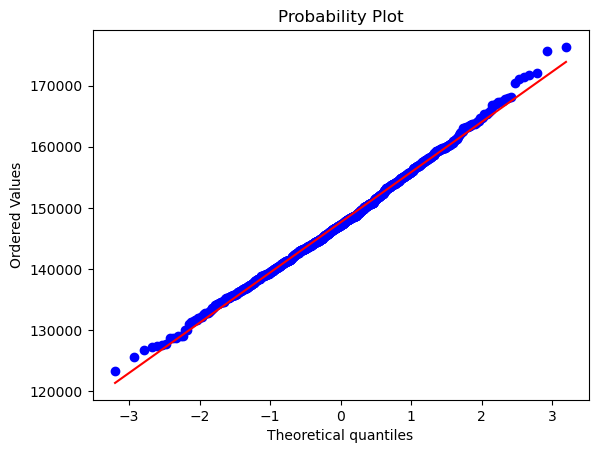

In [175]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

We see that there are discrepancies with the normal distribution. Therefore, we should not rely on the t-test. We will build the same chart for salaries for all the leaving ones.

In [176]:
t = pd.Series(
    [values_2.sample(
        300,replace=True).mean() for _ in range(1000)])

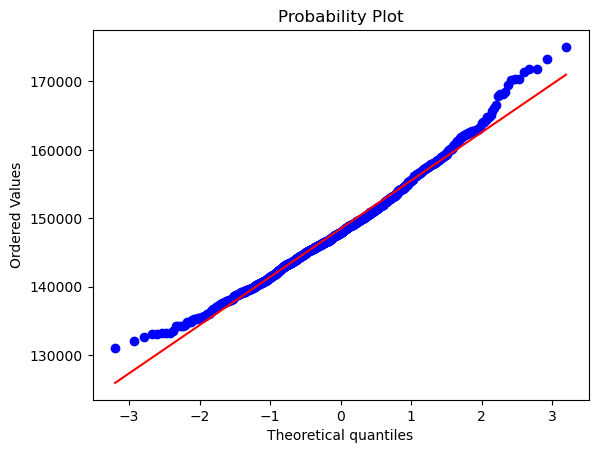

In [177]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

And here, too, there are discrepancies. Therefore, it is better to focus on the results of the Mann-Whitney test. It told us that in both cases there is a stat. significance:
* the average salary for outflow customers significantly differs from the salary of non-outflow ones;
* the average salary of those with a salary from 100 to 250 th.rub. significantly differs from the average salary of the rest of the leaving ones.

## Scoring

We can immediately check how the sample scoring averages are distributed. Let's take our problem area - outflow clients with scores from 820 to 930. And we'll take all the outflow ones. We will generate sample averages based on this data. Let's build a qq plot for both generated sample averages.

We will start from scoring scores for all outflow clients.

In [178]:
score_no_churn = data.query('churn==0')['score']
score_churn = data.query('churn==1')['score']

score_bad_churn = data.query('820<=score<=930 and churn==1')['score']
score_no_bad_churn = data[~data['score'].isin(score_bad_churn)]['score']

In [179]:
t = pd.Series(
    [score_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

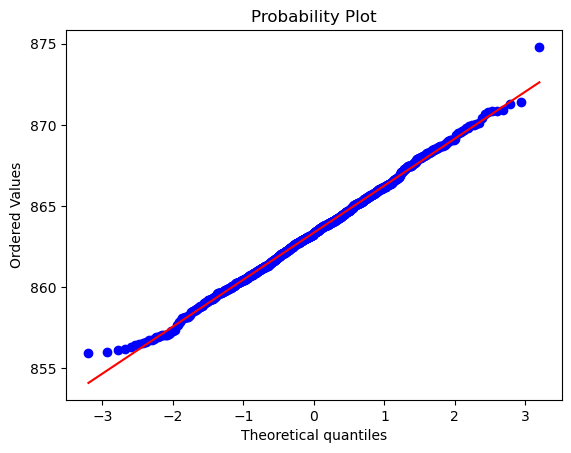

In [180]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

We see a slight discrepancy with the normal distribution. The values at the edges bounced off the diagonal.

Now we will do the same for the leaving ones with scores from 820 to 930.

In [181]:
t = pd.Series(
    [score_bad_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

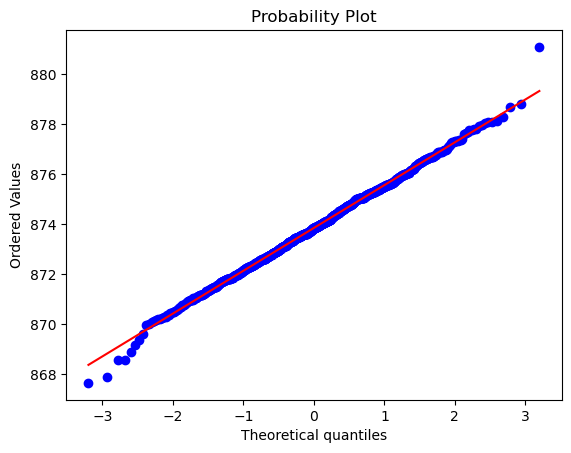

In [182]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

Here the distribution of averages doesn't look like normal. Let's pick here the Mann-Whitney test.

We should look again at out averages.

In [183]:
mean_comparison ('score', 820, 930)

,показатель,значение
0,non-outflow average,845.436451
1,outflow average,863.361936
2,outflow average for problem zone,873.800152
3,outflow average excluding problem zone,835.998008


The clients with biggest outflow have a scoring score from 820 to 930. Let's compare the average of the outflow and non-outflow ones. And also the average of the customers with biggest outflow with the average of the rest of the leaving ones.

**Null hypothesis: the average score of non-leaving clients does not differ significantly from the average score of leaving clients.\
Alternative hypothesis: There is a significant difference in the average scoring scores.**

In [184]:
mw(alpha, score_no_churn, score_churn)

p-value 6.072014214738013e-22
We reject the null hypothesis: there are statistically significant differences in the mean values.


**Null hypothesis: the average score of the leaing clients with scores from 820 to 930  does not differ significantly from the average score of the other leaving clients.
Alternative hypothesis: There is a significant difference in the average scoring scores.**

In [185]:
mw(alpha, score_bad_churn, score_no_bad_churn)

p-value 1.2956120600666964e-218
We reject the null hypothesis: there are statistically significant differences in the mean values.


In both cases there is a stat.significant differences. So it can be assumed that high-quality customers have a different credit scoring score. We can assume the same for the leaving clients with scores from 830 to 920.

## Age

Comparing the averages, we saw that leaving and non-leaving clients have similar average age. Let's find out if the test finds the differences.

First, let's build a qq plot for both samples. The age dispersion should be smaller, and the Student's test may also be suitable.

In [186]:
age_churn = data.query('churn==1')['age']
age_no_churn = data.query('churn==0')['age']

print(data.query('churn==1')['age'].mean())
data.query('churn==0')['age'].mean()

41.42959295929593


43.01628825271471

In [187]:
t = pd.Series(
    [age_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

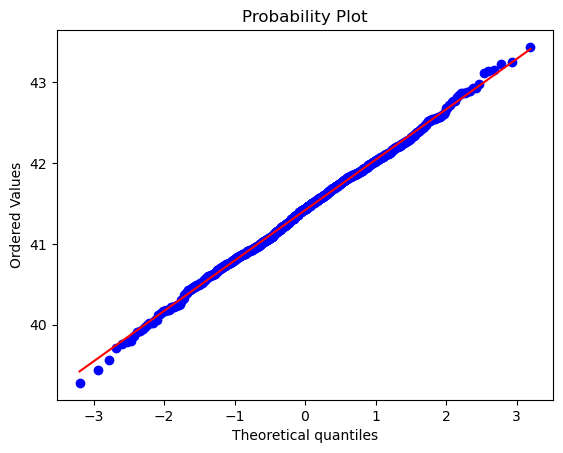

In [188]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

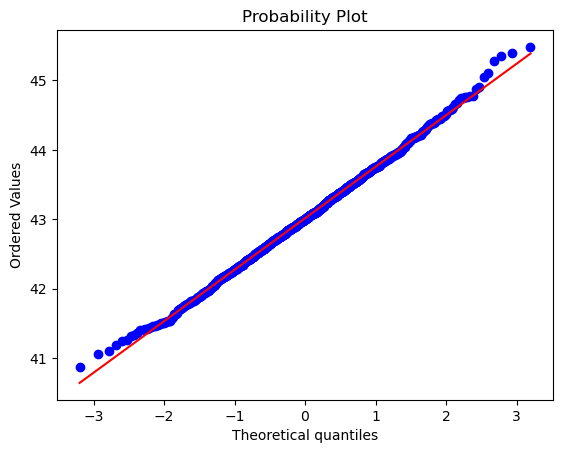

In [189]:
t = pd.Series(
    [age_no_churn.sample(
        300,replace=True).mean() for _ in range(1000)])

stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

The distributions have discrepancies with the normal. We should use the Mann-Whitney criterion again.

**Null hypothesis: the average age of outflow clients does not differ significantly from the average age of non-outflow ones.
Alternative hypothesis: there is a significant difference in average age.**

We have only one hypothesis to test, so we do not adjust the level of significance here.

In [190]:
alpha=0.05
mw(alpha, age_no_churn, age_churn)

p-value 4.122295485981862e-06
We reject the null hypothesis: there are statistically significant differences in the mean values.


The differences in 1.5 years turned out to be stat. significant for our samples. We will consider that the leaving clients have a different age, probably higher.

## Conclusions to the section

* In all tests, we used the Mann-Whitney test, since there are outliers in our data, which does not allow the sample averages to be distributed normally.
* The test indicates significant differences in the salary of the leaving and non-leaving. As well as for those who have been leaving with a salary from 100 on to 250 th.rub and the rest of the leaving ones. It can be concluded that outgoing clients have their own explicit portrait, as well as outgoing with highest probability ones.
* The test indicates a significant difference in the average scoring scores for leaving and not. As well as leaving with hisghest probability (from 820 to 930 points incl.) and the rest of the leaving. So the scoring score also can help in distinguishing the probability of outflow.
* The differences in the average age of 1.5 years of leaving and non-leaving turned out to be stat. significant. It can be assumed that age significantly affects the probability of outflow if a person is already in the category of outflow.

# Drawing up a portrait and recommendations for customer retention¶

## Let's recall the useful conclusions of the previous sections

We have a lot to choose from to create portraits of clients who are leaving the bank with high probability:

* Customers with 3,4,5 products exceed the average value of the dataset by at least 1.6 times.
* Customers with 3 property points have a 16% higher churn rate than the average. Customers with 4 points 38% higher. 
* Customers with an even higher number of points by at least 66%, depending on the points.
* Every city is very close to the average, there are no significant differences.
* The share of leaving clients among men exceeds the average of 18%.
* People without a credit card are about 1.42 times more likely to leave.
* People with recent significant activity are about 1.36 times more likely than average to be close to leaving the bank.

* On the basis of salary, the problem area is customers with a salary from 100 to 250 th.rub.
Their average significantly differs from the average salary of other outgoing customers. This means that customers who fall into such group tell us that we need to pay attention to them and keep them in the bank.

* Based on the balance, problem area is clients with a balance from 1 million rubles to 4.5 million rubles.
For clients with a balance from 1 to 4.5 million, the average is 2.25 times more than the average for other clients leaving the bank. This means that outgoing customers with a balance from 1 to 4.5 million rubles is a sign that well characterizes people who can leave the bank.

* Based on age, the problem areas are clients up to 35 incl. and from 49 years old to 61 inclusive.
The problematic age categories are quite far from the average among the rest of the outflow clients. So these categories can be used when creating a portrait of an exact client.

* On the basis of credit scoring points, the problem area is clients who have from 820 on to 930 on points.
The average scoring score among leaving customers is 1.02 times higher than all data average. For leaving customers with a score from 820 to 930 million, the average is 1.01 times higher than for the rest of the leaving clients.
The difference is minimal, but the significance of the differences is there. We can assume that this is also an important feature that characterizes customers who tend to leave the bank.

The outflow/non-outflow column has the greatest relationship with property scores.\
Also higher than 0.1 is the relationship with credit scoring, gender, age, number of products, credit card, recent activity.

## Choosing groups with the least loyal customers

### Segments related to the number of products and property points

Firstly, let's take those indicators that correlate with outflow and non-outflow.

**Let's take male customers with 3,4,5 products.**

In [191]:
prod_male = data_initial.query('gender=="М" and (products==3 or products==4 or products==5)')

In [192]:
print(f'We have {prod_male.user_id.count()} such clients.\
 Proportion of outflow clients is {prod_male.churn.mean():.2%}.\
 It is {(prod_male.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 747 such clients. Proportion of outflow clients is 50.33%. It is 2.7 times more, than all data average.


But we can segment even deeper using age. To offer customers something more relevant. For example, let's take customers aged 49 to 61. We see that the outflow level among them is even more than 50%. But the group is quite small.

In [193]:
prod_age_male = prod_male.query('49<=age<=61')

In [194]:
print(f'We have {prod_age_male.user_id.count()} such clients.\
 Proportion of outflow clients is {prod_age_male.churn.mean():.2%}.\
 It is {(prod_age_male.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 166 such clients. Proportion of outflow clients is 60.24%. It is 3.3 times more, than all data average.


If we take people under 35, then we will get an outflow even less than if we do not divide by age at all.

In [195]:
prod_age_male_1 = prod_male.loc[(~prod_male['age'].isin(prod_age_male['age']))]
prod_age_male_1 = prod_age_male_1.query('age<35')

In [196]:
print(f'We have {prod_age_male_1.user_id.count()} such clients.\
 Proportion of outflow clients is {prod_age_male_1.churn.mean():.2%}.\
 It is {(prod_age_male_1.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 232 such clients. Proportion of outflow clients is 48.71%. It is 2.7 times more, than all data average.


As a result, we will not break down leaving clients by age and take all men with 3,4 or 5 products.

**Now let's take men who have from 4 property points.**\
We should filter the dataset so that people with 3,4 or 5 products don't get there because we should minimize intersections with previous group.

In [197]:
equity_male = data_initial.loc[(~data_initial['user_id'].isin(prod_male['user_id']))]

equity_male = equity_male.query('gender=="М" and equity>=4')

In [198]:
print(f'We have {equity_male.user_id.count()} such clients.\
 Proportion of outflow clients is {equity_male.churn.mean():.2%}.\
 It is {(equity_male.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 1491 such clients. Proportion of outflow clients is 32.39%. It is 1.8 times more, than all data average.


If we try to single out a group of people under 35, we won't see much difference.

In [199]:
equity_male_1 = equity_male.query('age<=35')

In [200]:
print(f'We have {equity_male_1.user_id.count()} such clients.\
 Proportion of outflow clients is {equity_male_1.churn.mean():.2%}.\
 It is {(equity_male_1.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 585 such clients. Proportion of outflow clients is 36.92%. It is 2.0 times more, than all data average.


The group of people from 49 to 61 is too small. Less than 300.

In [201]:
equity_male_2 = equity_male.query('49<=age<=61')

In [202]:
print(f'We have {equity_male_2.user_id.count()} such clients.\
 Proportion of outflow clients is {equity_male_2.churn.mean():.2%}.\
 It is {(equity_male_2.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 284 such clients. Proportion of outflow clients is 38.73%. It is 2.1 times more, than all data average.


Therefore, we will focus on all men with 4 points or more.

### Segments based on gender, scoring, age, credit card availability, activity

**Now let's take male customers and without a credit card.**\
We will filter it so that there are no matches with 'prod_male' and 'equity_male'.
That is, we leave males, but we remove those who have 3,4 or 5 products and from 4 property points.

In [203]:
def churn_portrait(value_1, value_2, indicator, gender):
    
    portrait = data_initial.loc[(~data_initial['products'].isin(prod_male['user_id']))&(
                                 ~data_initial['equity'].isin(equity_male['equity']))]

    portrait = portrait.loc[(portrait[indicator]>=value_1)&(portrait[indicator]<=value_2)]
    portrait = portrait[portrait['gender']==gender]
    print(f'We have {portrait.user_id.count()} people in group.')
    print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

In [204]:
churn_portrait(0, 0, 'credit_card', 'М')

We have 597 people in group.
Outflow proportion is 18.26%.


Too small proportion of outflowing clients. Very close to all data average. We need biggest number.

**Now let's take male clients and those under the age of 35 and from 49 to 61 among those whom we have not yet considered.**

In [205]:
churn_portrait(49, 61, 'age', 'М')

We have 509 people in group.
Outflow proportion is 20.24%.


Among the remaining people from 49 to 61, the outflow is close to the average. If we choose females, then there are even fewer clients who are ready to leave the bank.

In [206]:
churn_portrait(0, 35, 'age', 'М')

We have 1160 people in group.
Outflow proportion is 14.57%.


Among the remaining people under 35 the outflow is less than average. It means that those clients who have much higher outflow rate we have already chosen while picking clients with 4 and more equity points or 3 and more products.

**Now we can search through those clients who recenrly had significant activity**.

Of course, we will not take into account those who have already been chosen.

In [207]:
age = churn_portrait(1, 1, 'last_activity', 'М')

We have 1518 people in group.
Outflow proportion is 16.60%.


We see that there are no customers left who have an outflow above average.

**Let's look at the scoring points.**

In [208]:
churn_portrait(820, 930, 'score', 'М')

We have 1463 people in group.
Outflow proportion is 16.13%.


If we take gender, age, scoring, credit card availability and activity as the basis for the division, then there are no interesting segments. Let's look at the division, where we take the salary and balance as a basis with the addition of other characteristics.

### Segments based on salary and balance

**Salary.**

Let's see what happens if we select a segment that has a male gender and does not intersect with the already selected segments at all and has a range of salary from 100 to 250 tr.

In [209]:
churn_portrait(100000, 250000, 'est_salary', 'М')

We have 1647 people in group.
Outflow proportion is 13.72%.


Outflow is too small. We will try to select all the men with a salary also from 100 to 250, male gender and age from 49 to 61. We will not set strict criteria for intersection.

In [210]:
portrait = data_initial.loc[(data_initial['est_salary']>=100000)&(data_initial['est_salary']<=250000)]
portrait = portrait[portrait['gender']=='М']
portrait = portrait.query('49<=age<=61')

print(f'We have {portrait.user_id.count()} people.')
print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

We have 447 people.
Outflow proportion is 30.65%.


The segment is not very large, and the share of outflow is too small for this size. Let's look at the same parameters, only under the age of 35.

In [211]:
portrait = data_initial.loc[(data_initial['est_salary']>=100000)&(data_initial['est_salary']<=250000)]
portrait = portrait[portrait['gender']=='М']

portrait = portrait.query('age<35')
print(f'We have {portrait.user_id.count()} people.')
print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

We have 702 people.
Outflow proportion is 28.35%.


We get too little outflow. What will happen if we do not use gender criteria.

In [212]:
portrait = data_initial.loc[(data_initial['est_salary']>=100000)&(data_initial['est_salary']<=250000)]

portrait = portrait.query('age<35')
print(f'We have {portrait.user_id.count()} people.')
print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

We have 1170 people.
Outflow proportion is 26.24%.


Again we get too little outflow. 

**Balance.**

Based on the balance, even several good segments can be considered.
The first is men and women aged 49 to 61 years with a balance of 1 million rubles to 4.5 million rubles.

In [213]:
portrait = data_initial.loc[(data_initial['balance']>=1000000)&(data_initial['balance']<=4500000)]
portrait = portrait.query('49<=age<=61')

print(f'We have {portrait.user_id.count()} people.')
print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

We have 482 people.
Outflow proportion is 45.44%.


But if we remove the age limit and include a male gender, then there will be more outflow and more people.

So the second group is men with a balance from 1 million rubles to 4.5 million rubles.

In [214]:
portrait = data_initial.loc[(data_initial['balance']>=1000000)&(data_initial['balance']<=4500000)]
portrait = portrait[portrait['gender']=='М']

print(f'We have {portrait.user_id.count()} people.')
print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

We have 914 people.
Outflow proportion is 49.34%.


This segment has a large intersection with the already selected two segments on the basis of property points and products.
If we subtract the intersection, the segment will shrink to such values.

In [215]:
portrait = data_initial.loc[(~data_initial['products'].isin(prod_male['products']))&(
                                 ~data_initial['equity'].isin(equity_male['equity']))]

portrait = portrait.loc[(data_initial['balance']>=1000000)&(portrait['balance']<=4500000)]
portrait = portrait[portrait['gender']=='М']

print(f'We have {portrait.user_id.count()} people.')
print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

We have 150 people.
Outflow proportion is 34.67%.


The third segment based on the balance is men under 35 years of age with a balance from 1 million rubles to 4.5 million rubles.

In [216]:
balance_age = data_initial.loc[(data_initial['balance']>=1000000)&(data_initial['balance']<=4500000)]
balance_age = balance_age.query('35<=age')
balance_age = balance_age[balance_age['gender']=='М']

print(f'We have {balance_age.user_id.count()} people.')
print(f'Outflow proportion is {balance_age.churn.mean():.2%}.')

We have 735 people.
Outflow proportion is 45.44%.


This segment has significantly less overlap with the already selected two segments on the basis of property points and products. If we subtract the intersection, the segment will shrink to such values.

In [217]:
portrait = data_initial.loc[(~data_initial['products'].isin(prod_male['products']))&(
                                 ~data_initial['equity'].isin(equity_male['equity']))]

portrait = portrait.loc[(portrait['balance']>=1000000)&(portrait['balance']<=4500000)]
portrait = portrait.query('35<=age')
portrait = portrait[portrait['gender']=='М']

print(f'We have {portrait.user_id.count()} people.')
print(f'Outflow proportion is {portrait.churn.mean():.2%}.')

We have 126 people.
Outflow proportion is 30.95%.


So this third segment will suit us.

## Conclusion to the section and suggestions for customer retention

We got 3 segments:\
**1) Male clients with 3,4,5 products.**

In [218]:
print(f'We have {prod_male.user_id.count()} such clients.\
 Proportion of outflow clients is {prod_male.churn.mean():.2%}.\
 It is {(prod_male.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 747 such clients. Proportion of outflow clients is 50.33%. It is 2.7 times more, than all data average.


These people actively use banking products. Probably in other banks they also use something. Among them there are middle-aged people.

1) We can propose to them something in connection to the family.
* We can issue debit or credit cards for family members which are linked to the same account. For such cards, we can set a special gradation of cashbacks depending.
* We can try to offer products related to health insurance for all family members and for children in particular.
Perhaps we have partners/clients of legal entities among medical clinics, we can contact them and arrange medical check-ups for clients and their families on good terms.
* We can offer travel insurance for the family.
* We can try to issue debit cards for children starting, say, from the age of 14 with a link to the father/mother account.
* Actively promote mortgage programs with good interest rates, relying not only on the income of the client, but also the whole family. If we see that the family as a whole is wealthy, then we can offer more pleasant conditions.

2) Those people who actively use banking products, they almost certainly use something related to the accumulation of funds and saving.
* Depending on the expenses on all family members' cards, we can offer an increased deposit rate for the limited amount of the deposit, say, within 10 million rubles.
* Similarly, we can vary interest rate of deposits depending on the expenses of the account holders.
* We can reduce the commission for asset management, brokerage services in the bank with certain investment amounts.

3) Loans, credit cards, mortgages.
* We can offer a credit card with a long interest-free period if the client spends more than a certain amount per month with the card.
* Perhaps clients are thinking to buy a home or have a mortgage in our or another bank. Then we can offer interesting mortgage rates depending on the volume of assets, the amount of spending using our credit/debit cards. That will help to attract activity and their capital of the client to our bank.

4) Clients may be interested in traveling, so we can offer the accumulation of miles for purchases, travel insurance. Increased cashback for the purchase of air tickets, hotel reservations.

**2) Male clients with 4 or more equity points.**

In [219]:
print(f'We have {equity_male.user_id.count()} such clients.\
 Proportion of outflow clients is {equity_male.churn.mean():.2%}.\
 It is {(equity_male.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 1491 such clients. Proportion of outflow clients is 32.39%. It is 1.8 times more, than all data average.


1) These customers have some property. Perhaps they are interested in insurance products for real estate, cars, countryside houses.

* It is possible that furniture stores are serviced in our babk as legal entities, we can contact them and give customers the opportunity to buy furniture by installments or using loan with a reduced rate.
* We can give the opportunity to repay insurance payments with cashback directly - to motivate people to use our cards.
* It is possible to increase the deposit rate when using our real estate insurance, i.e. it will be like a package offer for customers.

2) We can also offer them products for business, perhaps they are entrepreneurs.
* They can be offered a low rate for acquiring, provided that the client will keep a certain amount of funds in our bank as an individual.a person or as a legal person.
* Or similarly, we can reduce the cost of servicing a legal entity's account.

**3) Men under 35 years of age inclusive with a balance from 1 million rubles to 4.5 million rubles.**

In [220]:
print(f'We have {balance_age.user_id.count()} such clients.\
 Proportion of outflow clients is {balance_age.churn.mean():.2%}.\
 It is {(balance_age.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 735 such clients. Proportion of outflow clients is 45.44%. It is 2.5 times more, than all data average.


These are young clients but already with savings. In this regard, we can offer them something related to the accumulation of funds or spending.

* The options already mentioned are: an increase in interest on deposits and accounts depending on the money on the accounts, an increase in cashback depending on spending.
* For young affluent clients, the mortgage issue may also be of interest. Therefore, mortgage rates can be lowered depending on card expenses and assets in our bank accounts.
* These people may be interested in traveling, so we can offer the accumulation of miles for spending with our cards.

**Small summarize**

We have collected such amount of people in our groups.

In [221]:
balance_age.user_id.count()+equity_male.user_id.count()+prod_male.user_id.count()

2973

Number of intersections.

In [222]:
balance_age.user_id.count() - portrait.user_id.count()

609

Number of people minus intersections.

In [223]:
clean_number = balance_age.user_id.count()+equity_male.user_id.count()\
+prod_male.user_id.count()-balance_age.user_id.count()-portrait.user_id.count()
clean_number

2112

Number of leaving people minus intersections.

In [224]:
churn_rate = equity_male.churn.mean()*equity_male.user_id.count() +\
prod_male.churn.mean()*prod_male.user_id.count()+\
portrait.user_id.count()*portrait.churn.mean()
churn_rate

898.0

In [225]:
print(f'Of the total net number of people in the selected segments, the share of net outgoing customers\
 is {churn_rate/clean_number:.2%}.')

Of the total net number of people in the selected segments, the share of net outgoing customers is 42.52%.


# Final conclusions

**1) Correlation with churn.**

Property scores, recent activity, number of products, scoring, gender, and credit card are most strongly associated with outflow. There is a particularly strong connection with the first three in the list.\
Customers with 3,4,5 products exceed the average outflow of the dataset by at least 1.6 times.\
Customers with 3 equity points have a 16% higher churn rate than the average. Customers with 4 points have 38% higher rate. Customers with an even higher number of points by at least 66%, depending on the points.
Therefore, it is not surprising that high churn rate segments were formed based on ownership points and the number of products.\
The share of leaving clients among men exceeds the average by 18%.\
Although the latter activity correlates strongly with the outflow, we do not know what kind of activity it is. So we can't offer some options to the client. It may even be an activity in connection with the withdrawal of money. Therefore, we cannot concentrate on this feature.

**2)Segments with high churn rate and suggestion to the clients.**

We got 3 segments:\
-----**Male clients with 3,4,5 products.**

In [226]:
print(f'We have {prod_male.user_id.count()} such clients.\
 Proportion of outflow clients is {prod_male.churn.mean():.2%}.\
 It is {(prod_male.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 747 such clients. Proportion of outflow clients is 50.33%. It is 2.7 times more, than all data average.


These people actively use banking products. Probably in other banks they also use something. Among them there are middle-aged people.

1) We can propose to them something in connection to the family.
* We can issue debit or credit cards for family members which are linked to the same account. For such cards, we can set a special gradation of cashbacks depending.
* We can try to offer products related to health insurance for all family members and for children in particular.
Perhaps we have partners/clients of legal entities among medical clinics, you can contact them and arrange medical check-ups for clients and their families on good terms.
* We can offer travel insurance for the family.
* We can try to issue debit cards for children starting, say, from the age of 14 with a link to the father/mother account.
* Actively promote mortgage programs with good interest rates, relying not only on the income of the client, but also the whole family. If we see that the family as a whole is wealthy, then we can offer more pleasant conditions.

2) Those people who actively use banking products, they almost certainly use something related to the accumulation of funds and saving.
* Depending on the expenses on all family members' cards, we can offer an increased deposit rate for the limited amount of the deposit, say, within 10 million rubles.
* Similarly, we can vary interest rate of deposits depending on the expenses of the account holders.
* We can reduce the commission for asset management, brokerage services in the bank with certain investment amounts.

3) Loans, credit cards, mortgages.
* We can offer a credit card with a long interest-free period if the client spends more than a certain amount per month with the card.
* Perhaps clients are thinking to buy a home or have a mortgage in our or another bank. Then we can offer interesting mortgage rates depending on the volume of assets, the amount of spending using our credit/debit cards. That will help to attract activity and their capital of the client to our bank.

4) Clients may be interested in traveling, so we can offer the accumulation of miles for purchases, travel insurance. Increased cashback for the purchase of air tickets, hotel reservations.

**-----Male clients with 4 or more equity points.**

In [227]:
print(f'We have {equity_male.user_id.count()} such clients.\
 Proportion of outflow clients is {equity_male.churn.mean():.2%}.\
 It is {(equity_male.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 1491 such clients. Proportion of outflow clients is 32.39%. It is 1.8 times more, than all data average.


1) These customers have some property. Perhaps they are interested in insurance products for real estate, cars, countryside houses.

* It is possible that furniture stores are serviced in our babk as legal entities, we can contact them and give customers the opportunity to buy furniture by installments or using loan with a reduced rate.
* We can give the opportunity to repay insurance payments with cashback directly - to motivate people to use our cards.
* It is possible to increase the deposit rate when using our real estate insurance, i.e. it will be like a package offer for customers.

2) We can also offer them products for business, perhaps they are entrepreneurs.
* They can be offered a low rate for acquiring, provided that the client will keep a certain amount of funds in our bank as an individual.a person or as a legal person.
* Or similarly, we can reduce the cost of servicing a legal entity's account.

**-----Men under 35 years of age inclusive with a balance from 1 million rubles to 4.5 million rubles.**

In [228]:
print(f'We have {balance_age.user_id.count()} such clients.\
 Proportion of outflow clients is {balance_age.churn.mean():.2%}.\
 It is {(balance_age.churn.mean()/data.churn.mean()):.2} times more, than all data average.')

We have 735 such clients. Proportion of outflow clients is 45.44%. It is 2.5 times more, than all data average.


These are young clients but already with savings. In this regard, we can offer them something related to the accumulation of funds or spending.

* The options already mentioned are: an increase in interest on deposits and accounts depending on the money on the accounts, an increase in cashback depending on spending.
* For young affluent clients, the mortgage issue may also be of interest. Therefore, mortgage rates can be lowered depending on card expenses and assets in our bank accounts.
* These people may be interested in traveling, so we can offer the accumulation of miles for spending with our cards.

**3) Hypothesis test.**

* On the basis of salary, the problem area is customers with salary from 100 to 250 th.rub.
Their average significantly differs from the average salary of the rest of the leaving clients.

* On the basis of the balance, problem area is customers with a balance from 1 million rubles to 4.5 million rubles
The average balance among outflow customers is 1.55 times higher than the average for loyal ones.\
For clients with balance from 1 to 4.5 million, the average is 2.25 times more than the average for the rest of the leaving ones.
This means that outflow clients with a balance from 1 to 4.5 million rubles are a sign that well characterizes people who can leave the bank.

Salary and balance do not strongly correlate with outflow. So this is not the reason that people want to leave, but it can be a characteristic of outgoing customers. This tells us who our client is. It will help us to choose products that are more suitable for him.\
In general, we see that these are people with above-average incomes. They may be interested in traveling, investing, saving, they have property.

* Based on age, the problem areas are clients up to 35 incl. and from 49 years to 61 inclusive.
The average age of such groups of people is far enough from the average among the rest of the cleints. So these categories can be used when creating a portrait of leaving client.
* On the basis of credit scoring points, the problem area is clients who has from 820 on to 930 points.
The average score among leaving customers is 1.02 times higher than for other clients, but for leaving clients with a score from 820 to 930 million, the average is 1.01 times higher than for the rest of the leaving ones.
The difference is minimal, but it is statistically significant. We can assume that this is also an important feature that characterizes leaving customers.

We tried to use age when building a portrait, but this method greatly reduced the sample of clients, so it turned out to be not optimal. But we always keep in mind that there are many young and middle-aged people among the outflow. Based on this, recommendations were made.

Credit scoring have correlation with outflow. But it is difficult to interpret this indicator, so groups were divided on the basis of it after more comprehensible indicators. As a result, groups with a large outflow were not formed based on credit scores.